# Final Project: Classification of Beatles Authorship in Songs

# Import necessary packages

In [30]:
import numpy as np
import re
import math
import numpy.random as rnd
import sklearn
import sklearn.datasets as datasets
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import lyricsgenius as lg

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer

stop_words = set(stopwords.words('english')) - {'all'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christinedeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christinedeng/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christinedeng/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christinedeng/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [31]:
print(stop_words)

{'shouldn', 'themselves', 'didn', 'had', 'has', 'should', 'down', 'him', 'very', 'am', 'which', "aren't", 'won', 'both', 'her', 'with', 'can', 'aren', 'will', 'were', 'because', 'me', 'how', 'the', 'they', 'have', 'yourselves', 'against', 'wouldn', 'she', 'an', 'these', 'did', 'being', 'through', 'is', "haven't", 'shan', 'where', 'before', "won't", 'by', 'a', 'them', 'hers', 'd', 'having', "needn't", 'from', 'been', 'he', 'in', 'under', 'hadn', 'few', 'for', 'ain', 'at', 'but', 'so', "shouldn't", 'each', 'll', "you'll", 'ma', "weren't", 'does', 'it', "it's", 'below', 'o', 'mightn', "mustn't", 'his', "you'd", 'herself', 'are', 'up', 'same', 's', 'now', 'yours', "should've", 'out', 'just', 'needn', 'y', 'do', 're', 'if', 'your', 'theirs', "hadn't", 'of', 'there', 'our', 'weren', 'other', 'or', 'most', 'over', 'to', 'you', 'be', 'during', 'more', 'some', 'mustn', 'only', 'until', 'yourself', "shan't", "isn't", 'such', 'wasn', 'not', 'itself', "didn't", "you've", "mightn't", "she's", 'who'

# Classification of songs by the Beatles
### 1. Read in the data, clean it, drop irrelevant songs
### 2. Create new target column denoting whether song is written by the Beatles 
### 3. Get full lyrics for each song by calling LyricsGenius API

In [4]:
# initialize lyrics genius
genius = lg.Genius('fWpH2qBpJgBOv8errO6zvKHPdUM8XP1u2tbRpxV11igkNOxIYiqFQSm7yVdo4Cnf')

# read in the data
tracks_df = pd.read_csv('tracks.csv')
artists_df = pd.read_csv('artists.csv')
# tracks_df.head(5)
# artists_df.head(5)

# Drop old songs
tracks_df['date'] = pd.to_datetime(tracks_df['release_date'])
tracks_df['release_year'] = tracks_df['date'].dt.year
tracks_df = tracks_df.drop(['date'], axis=1)

non_beatles = tracks_df[~tracks_df.loc[:,'artists'].str.contains('The Beatles', na=False)]
beatles = tracks_df.drop(index=non_beatles.index, inplace=False)

to_drop = tracks_df[tracks_df.loc[:,'artists'].str.contains("The Beatles", na=False)]
new_df = tracks_df.drop(index=to_drop.index, inplace=False)
to_drop = new_df[new_df['release_year'] > 1970]
new_df = new_df.drop(index=to_drop.index, inplace=False)
to_drop = new_df[new_df['release_year'] < 1963]
new_df = new_df.drop(index=to_drop.index, inplace=False)
to_drop = new_df[new_df['popularity'] < 37]
new_df = new_df.drop(index=to_drop.index, inplace=False)
to_drop = new_df[new_df['popularity'] > 63]
new_df = new_df.drop(index=to_drop.index, inplace=False)

# for i in tracks_df.index: 
#     if tracks_df.loc[i]['artists'] != '':
#         if 'The Beatles' in tracks_df.loc[i]['artists']: 
#             print(tracks_df.loc[i]['release_year'])

tracks_df.reset_index(drop=True, inplace=True)
artists_df.reset_index(drop=True, inplace=True)

tracks_df = beatles.append(new_df)

# Create new target column that denotes whether song is by The Beatles or not 
tracks_df['target'] = tracks_df.loc[:,'artists'].str.contains('The Beatles', na=False)

songs_list = tracks_df['name'].tolist()
artists_list = tracks_df['artists'].tolist()
to_drop = []

# Function to get lyrics from LyricsGenius for list of songs and artists
def get_lyrics(songs, artists):
    i = 0
    lyrics = []
    for song in songs:
        if song != None:
            try:
                lyrics.append(re.sub("\n", " ", genius.search_song(song, artists[i]).lyrics))
                # lyrics.append(genius.search_song(songs[i], artists[i]).lyrics)
            except:
                lyrics.append("")
        else:
            to_drop.append(i)
        i += 1
    return lyrics

# Get the lyrics
lyrics_list = get_lyrics(songs_list, artists_list)

Searching for "Twist And Shout - Remastered 2009" by The Beatles...
Done.
Searching for "I Saw Her Standing There - Remastered 2009" by The Beatles...
Done.
Searching for "Love Me Do - Remastered 2009" by The Beatles...
Done.
Searching for "All My Loving - Remastered 2009" by The Beatles...
Done.
Searching for "Till There Was You - Remastered 2009" by The Beatles...
Done.
Searching for "Do You Want To Know A Secret - Remastered 2009" by The Beatles...
Done.
Searching for "Please Please Me - Remastered 2009" by The Beatles...
Done.
Searching for "Anna (Go To Him) - Remastered 2009" by The Beatles...
No results found for: 'Anna (Go To Him) - Remastered 2009 The Beatles'
Searching for "Baby Its You - Remastered 2009" by The Beatles...
Done.
Searching for "Roll Over Beethoven - Remastered 2009" by The Beatles...
Done.
Searching for "You Really Got A Hold On Me - Remastered 2009" by The Beatles...
Done.
Searching for "All Ive Got To Do - Remastered 2009" by The Beatles...
Done.
Searching fo

No results found for: 'Strawberry Fields Forever - Remastered 2009 The Beatles'
Searching for "Lucy In The Sky With Diamonds - Remastered 2009" by The Beatles...
No results found for: 'Lucy In The Sky With Diamonds - Remastered 2009 The Beatles'
Searching for "All You Need Is Love - Remastered 2009" by The Beatles...
Done.
Searching for "Penny Lane - Remastered 2009" by The Beatles...
No results found for: 'Penny Lane - Remastered 2009 The Beatles'
Searching for "With A Little Help From My Friends - Remastered 2009" by The Beatles...
Done.
Searching for "A Day In The Life - Remastered 2009" by The Beatles...
Done.
Searching for "Hello Goodbye - Remastered 2009" by The Beatles...
Done.
Searching for "Sgt. Peppers Lonely Hearts Club Band - Remastered 2009" by The Beatles...
Done.
Searching for "When Im Sixty Four - Remastered 2009" by The Beatles...
Done.
Searching for "I Am The Walrus - Remastered 2009" by The Beatles...
Done.
Searching for "Shes Leaving Home - Remastered 2009" by The B

Done.
Searching for "Maxwells Silver Hammer - Remastered 2009" by The Beatles...
Done.
Searching for "You Never Give Me Your Money - Remastered 2009" by The Beatles...
Done.
Searching for "She Came In Through The Bathroom Window - Remastered 2009" by The Beatles...
No results found for: 'She Came In Through The Bathroom Window - Remastered 2009 The Beatles'
Searching for "The End - Remastered 2009" by The Beatles...
Done.
Searching for "Sun King - Remastered 2009" by The Beatles...
Done.
Searching for "Mean Mr Mustard - Remastered 2009" by The Beatles...
No results found for: 'Mean Mr Mustard - Remastered 2009 The Beatles'
Searching for "Polythene Pam - Remastered 2009" by The Beatles...
No results found for: 'Polythene Pam - Remastered 2009 The Beatles'
Searching for "Hey Bulldog - Remastered 2009" by The Beatles...
No results found for: 'Hey Bulldog - Remastered 2009 The Beatles'
Searching for "Oh! Darling - 2019 Mix" by The Beatles...
Done.
Searching for "Yellow Submarine - Remaster

No results found for: 'Komm gib mir deine Hand - Remastered 2009 The Beatles'
Searching for "Hey Jude - Remastered 2009" by The Beatles...
Done.
Searching for "Shes A Woman - Remastered 2009" by The Beatles...
Done.
Searching for "Day Tripper - Remastered 2009" by The Beatles...
No results found for: 'Day Tripper - Remastered 2009 The Beatles'
Searching for "Long Tall Sally - Remastered 2009" by The Beatles...
Done.
Searching for "Free As A Bird - Anthology 1 Version" by The Beatles...
No results found for: 'Free As A Bird - Anthology 1 Version The Beatles'
Searching for "Real Love - Anthology 2 Version" by The Beatles...
Done.
Searching for "Hey Jude - Remastered 2015" by The Beatles...
Done.
Searching for "I Want To Hold Your Hand - Remastered 2015" by The Beatles...
Done.
Searching for "She Loves You - Mono / Remastered" by The Beatles...
Done.
Searching for "Day Tripper - Remastered 2015" by The Beatles...
No results found for: 'Day Tripper - Remastered 2015 The Beatles'
Searching 

Done.
Searching for "I Call Your Name - Remastered 2009" by The Beatles...
Done.
Searching for "Revolution - Remastered 2009" by The Beatles...
Done.
Searching for "You Know My Name (Look Up The Number) - Remastered 2009" by The Beatles...
Done.
Searching for "We Can Work It Out - Remastered 2009" by The Beatles...
Done.
Searching for "Slow Down - Remastered 2009" by The Beatles...
Done.
Searching for "I Feel Fine - Remastered 2009" by The Beatles...
Done.
Searching for "Love Me Do - Single Version / Remastered 2009" by The Beatles...
Done.
Searching for "Besame Mucho - Anthology 1 Version" by The Beatles...
Done.
Searching for "When Im Sixty Four" by The Beatles...
Done.
Searching for "Oh! Darling - Take 4" by The Beatles...
Done.
Searching for "The Ballad Of John And Yoko - Remastered 2009" by The Beatles...
No results found for: 'The Ballad Of John And Yoko - Remastered 2009 The Beatles'
Searching for "Let It Be - Remastered 2009" by The Beatles...
Done.
Searching for "Cant Buy Me L

Done.
Searching for "My One And Only Love" by John Coltrane Johnny Hartman...
Done.
Searching for "Fly Me To The Moon (In Other Words)" by Julie London...
Done.
Searching for "Do Wah Diddy Diddy - 2007 Remaster" by Manfred Mann...
No results found for: 'Do Wah Diddy Diddy - 2007 Remaster Manfred Mann'
Searching for "For Me Formidable" by Charles Aznavour...
Done.
Searching for "Dont Think Twice Its All Right" by Peter Paul and Mary...
Done.
Searching for "Cant Take My Eyes Off You" by Andy Williams...
Done.
Searching for "Summer Holiday - 2003 Remaster" by Cliff Richard The Shadows...
Done.
Searching for "Puff the Magic Dragon" by Peter Paul and Mary...
Done.
Searching for "Sleigh Ride" by The Ronettes...
Done.
Searching for "Chitlins Con Carne" by Kenny Burrell...
No results found for: 'Chitlins Con Carne Kenny Burrell'
Searching for "Midnight Blue - Remastered" by Kenny Burrell...
No results found for: 'Midnight Blue - Remastered Kenny Burrell'
Searching for "In Dreams" by Roy Orbiso

Done.
Searching for "Brazil (Aka Aquarela do Brasil)" by Antônio Carlos Jobim...
No results found for: 'Brazil (Aka Aquarela do Brasil) Antônio Carlos Jobim'
Searching for "Angelica" by Duke Ellington John Coltrane...
No results found for: 'Angelica Duke Ellington John Coltrane'
Searching for "Love Theme From Spartacus" by Bill Evans...
Done.
Searching for "Our Day Will Come" by Julie London...
Done.
Searching for "Apache" by The Shadows...
Specified song does not contain lyrics. Rejecting.
Searching for "The Last Leaf" by The Cascades...
Done.
Searching for "Bir Eylül Akşamı - 45lik" by Erkin Koray...
No results found for: 'Bir Eylül Akşamı - 45lik Erkin Koray'
Searching for "Bachelor Boy - 2003 Remaster" by Cliff Richard The Shadows...
Done.
Searching for "Bon anniversaire" by Charles Aznavour...
Done.
Searching for "Caterpillar Crawl" by The Lively Ones...
Done.
Searching for "Yakety Sax" by Boots Randolph...
Specified song does not contain lyrics. Rejecting.
Searching for "Moon Riv

Done.
Searching for "I Washed My Hands in Muddy Water" by Stonewall Jackson...
Done.
Searching for "Shapes of Things - 2015 Remaster" by The Yardbirds...
No results found for: 'Shapes of Things - 2015 Remaster The Yardbirds'
Searching for "La montagne" by Jean Ferrat...
Done.
Searching for "The Man Who Plays The Mandolino" by Dean Martin...
Done.
Searching for "He Sabido Que Te Amaba (Ho Capito Che Ti Amo)" by Javier Solís...
No results found for: 'He Sabido Que Te Amaba (Ho Capito Che Ti Amo) Javier Solís'
Searching for "Sonata in A Minor K 59 (L 241)" by Domenico Scarlatti Vladimir Horowitz...
No results found for: 'Sonata in A Minor K 59 (L 241) Domenico Scarlatti Vladimir Horowitz'
Searching for "Will the Circle Be Unbroken" by The Carter Family Johnny Cash...
Done.
Searching for "You Send Me - Live" by Sam Cooke...
Done.
Searching for "Things" by Dean Martin...
Done.
Searching for "Y..." by Eydie Gormé Los Panchos...
Done.
Searching for "Plein soleil" by Gilbert Bécaud...
Done.
Se

No results found for: 'For a Few Dollars More - Main Theme Ennio Morricone'
Searching for "Brev från kolonien" by Cornelis Vreeswijk...
Done.
Searching for "Make Someone Happy" by Jimmy Durante...
Done.
Searching for "My Name Is Carnival - 2001 Remaster" by Jackson C. Frank...
Done.
Searching for "I Want to Thank You" by Otis Redding...
Done.
Searching for "Watermelon Man" by Mongo Santamaria...
Done.
Searching for "Mood" by Miles Davis...
Specified song does not contain lyrics. Rejecting.
Searching for "A Love Supreme Pt. IV - Psalm" by John Coltrane...
Done.
Searching for "Early In the Morning - 2006 Remastered Version" by "Alexis Korners Blues Incorporated"...
No results found for: 'Early In the Morning - 2006 Remastered Version "Alexis Korners Blues Incorporated"'
Searching for "Strychnine" by The Sonics...
Done.
Searching for "Come to Me" by Otis Redding...
Done.
Searching for "Baby Im In The Mood For You" by Odetta...
Done.
Searching for "Cello Concerto in E Minor Op.85 (1997 - R

Done.
Searching for "Rosas en el Mar" by Massiel...
Done.
Searching for "D-I-V-O-R-C-E" by Tammy Wynette...
Done.
Searching for "Cant Seem To Make You Mine" by The Seeds...
Done.
Searching for "Go Where You Wanna Go" by The Mamas & The Papas...
Done.
Searching for "Silver Bells" by Dean Martin...
Done.
Searching for "Black is Black" by Los Bravos...
Done.
Searching for "Satisfaction" by Carl Dawkins...
Done.
Searching for "Walk Through This World With Me" by George Jones...
Done.
Searching for "The Bottle Let Me Down" by Merle Haggard & The Strangers...
Done.
Searching for "Rose Garden" by Lynn Anderson...
Done.
Searching for "A 200 à lheure - Instrumental" by Francis Lai...
Done.
Searching for "Cool Jerk" by The Capitols...
Done.
Searching for "Django - Main Theme - English Version" by Luis Bacalov...
No results found for: 'Django - Main Theme - English Version Luis Bacalov'
Searching for "Unsquare Dance" by Dave Brubeck...
Specified song does not contain lyrics. Rejecting.
Searching 

Specified song does not contain lyrics. Rejecting.
Searching for "Visions - 2005 Remaster" by Cliff Richard...
Done.
Searching for "El Bueno El Feo Y El Malo - II Buono II Brutto Il Cattivo - Tema principal" by Ennio Morricone...
No results found for: 'El Bueno El Feo Y El Malo - II Buono II Brutto Il Cattivo - Tema principal Ennio Morricone'
Searching for "Gentle On My Mind" by John Hartford...
Done.
Searching for "You Baby" by The Mamas & The Papas...
Done.
Searching for "Manha De Carneval" by Baden Powell...
Done.
Searching for "The Ecstasy Of Gold" by Ennio Morricone...
Specified song does not contain lyrics. Rejecting.
Searching for "Emmenez-moi" by Charles Aznavour...
Done.
Searching for "Gentle On My Mind - Remastered 2001" by Glen Campbell...
Done.
Searching for "Knock on Wood" by Eddie Floyd...
Done.
Searching for "Alone Again Or - 2015 Remaster" by Love...
Done.
Searching for "The Girl From Ipanema" by Antônio Carlos Jobim Frank Sinatra...
Done.
Searching for "Groovin" by The

No results found for: 'Drinking Water (Aqua de Beber) Antônio Carlos Jobim Frank Sinatra'
Searching for "Caballo Golondrino" by Vicente Fernández...
Done.
Searching for "Les filles de mon pays" by Enrico Macias...
Done.
Searching for "Aranjuez mon amour" by Richard Anthony...
Done.
Searching for "Today" by Tom Scott California Dreamers...
Done.
Searching for "Requiem For John Hurt" by John Fahey...
Specified song does not contain lyrics. Rejecting.
Searching for "a) STRA (Illusions Of My Childhood-Part One) b)You Keep Me Hanging On c) WBER (Illusions Of My Childhood-Part Two)" by Vanilla Fudge...
No results found for: 'a) STRA (Illusions Of My Childhood-Part One) b)You Keep Me Hanging On c) WBER (Illusions Of My Childhood-Part Two) Vanilla Fudge'
Searching for "Preghiera in Gennaio" by Fabrizio De André...
Done.
Searching for "Dark End of the Street" by Percy Sledge...
Done.
Searching for "How Insensitive (Insensatez)" by Antônio Carlos Jobim Frank Sinatra...
No results found for: 'How

Done.
Searching for "Youve Made Me So Very Happy" by Blood Sweat & Tears...
Done.
Searching for "Livin in the Sunlight Lovin in the Moon Light" by Tiny Tim...
Done.
Searching for "Love Is Blue" by Marty Robbins...
Done.
Searching for "Statesboro Blues" by Taj Mahal...
Done.
Searching for "Mr. Bojangles" by Jerry Jeff Walker...
Done.
Searching for "Do You Know the Way to San Jose" by Dionne Warwick...
Done.
Searching for "This Guys In Love With You" by Herb Alpert & The Tijuana Brass...
Done.
Searching for "Lets Go Get Stoned" by "Booker T. & the M.G.s"...
Done.
Searching for "As We Go Along" by The Monkees...
Done.
Searching for "Young Girl" by Gary Puckett & The Union Gap...
Done.
Searching for "La guerra di Piero" by Fabrizio De André...
Done.
Searching for "Mind Flowers" by Ultimate Spinach...
Done.
Searching for "Aint Got No - I Got Life - Single Version" by Nina Simone...
Done.
Searching for "Bring a Little Lovin" by Los Bravos...
Done.
Searching for "And When I Die" by Blood Swea

Done.
Searching for "Jennifer Juniper" by Donovan...
Done.
Searching for "Deirdres samba" by Cornelis Vreeswijk...
Done.
Searching for "Retrato do boi soberano" by Tião Carreiro & Pardinho...
Done.
Searching for "I Started A Joke" by Bee Gees...
Done.
Searching for "Gold And Silver" by Quicksilver Messenger Service...
Done.
Searching for "Okolona River Bottom Band" by Bobbie Gentry...
Done.
Searching for "Positively 4th Street - Remastered" by Johnny Rivers...
Done.
Searching for "Desperation" by Steppenwolf...
Done.
Searching for "Dont Think Twice Its All Right - Album Verison" by "Ramblin Jack Elliott"...
No results found for: 'Dont Think Twice Its All Right - Album Verison "Ramblin Jack Elliott"'
Searching for "Love Is Blue" by Gábor Szabó Jim Stewart Hal Gordon Jimmy Keltner Louis Kabok...
No results found for: 'Love Is Blue Gábor Szabó Jim Stewart Hal Gordon Jimmy Keltner Louis Kabok'
Searching for "Baby Blue" by The Chocolate Watchband...
Done.
Searching for "Someone I Know" by M

No results found for: 'Volunteers - Remastered Jefferson Airplane'
Searching for "Free Me" by Otis Redding...
Done.
Searching for "Simple Symphony Op.4: "Playful Pizzicato" from Simple Symphony Op. 4" by Benjamin Britten English Chamber Orchestra...
No results found for: 'Simple Symphony Op.4: "Playful Pizzicato" from Simple Symphony Op. 4 Benjamin Britten English Chamber Orchestra'
Searching for "Just A Little Bit Of Peace In My Heart" by Golden Earring...
Done.
Searching for "Colorado Girl" by Townes Van Zandt...
Done.
Searching for "Gröna små äpplen" by Monica Zetterlund...
Done.
Searching for "Beautiful People" by Melanie...
Done.
Searching for "Çapkın Kız" by Gönül Yazar...
No results found for: 'Çapkın Kız Gönül Yazar'
Searching for "Hey Thats No Way to Say Goodbye" by Roberta Flack...
Done.
Searching for "About Her Eyes" by Jerry Jeff Walker...
Done.
Searching for "Aquellas Pequeñas Cosas" by Joan Manuel Serrat...
Done.
Searching for "Violino" by Piero Piccioni...
Done.
Searchin

No results found for: 'Caravan - 2013 Remaster Van Morrison'
Searching for "Ill Never Fall in Love Again" by Dionne Warwick...
Done.
Searching for "Didnt I (Blow Your Mind This Time)" by The Delfonics...
Done.
Searching for "Muchacha (Ojos de Papel)" by Almendra...
Done.
Searching for "Thats the Way - Remaster" by Led Zeppelin...
Done.
Searching for "Minor Swing" by Django Reinhardt Stéphane Grappelli Quintette du Hot Club de France...
No results found for: 'Minor Swing Django Reinhardt Stéphane Grappelli Quintette du Hot Club de France'
Searching for "Knock Three Times" by Tony Orlando & Dawn...
Done.
Searching for "Who Loves the Sun - 2015 Remaster" by The Velvet Underground...
No results found for: 'Who Loves the Sun - 2015 Remaster The Velvet Underground'
Searching for "Bron-Y-Aur Stomp - Remaster" by Led Zeppelin...
No results found for: 'Bron-Y-Aur Stomp - Remaster Led Zeppelin'
Searching for "Behind Closed Doors" by Charlie Rich...
Done.
Searching for "I Think I Love You" by The

No results found for: 'Cumberland Blues - 2013 Remaster Grateful Dead'
Searching for "Dirt" by The Stooges...
Done.
Searching for "The Good Mr. Square" by The Pretty Things...
Done.
Searching for "Everyone - 2013 Remaster" by Van Morrison...
Done.
Searching for "Lágrima" by Francisco Tárrega Julian Bream...
No results found for: 'Lágrima Francisco Tárrega Julian Bream'
Searching for "Hey Joe" by Wilson Pickett...
Done.
Searching for "Into the Mystic - 2013 Remaster" by Van Morrison...
No results found for: 'Into the Mystic - 2013 Remaster Van Morrison'
Searching for "Sweet Jane - Full Length Version; 2015 Remaster" by The Velvet Underground...
No results found for: 'Sweet Jane - Full Length Version; 2015 Remaster The Velvet Underground'
Searching for "Come Running - 2013 Remaster" by Van Morrison...
No results found for: 'Come Running - 2013 Remaster Van Morrison'
Searching for "Let Me Try" by MC5...
Done.
Searching for "Miles Runs the Voodoo Down" by Miles Davis...
Specified song does

No results found for: 'Kimi kaishi Fausto Papetti'
Searching for "Main Theme (From "Schindlers List")" by Itzhak Perlman John Williams Pittsburgh Symphony Orchestra...
No results found for: 'Main Theme (From "Schindlers List") Itzhak Perlman John Williams Pittsburgh Symphony Orchestra'
Searching for "Did You Give the World Some Love Today Baby" by Doris...
Done.
Searching for "Refugees - Remastered" by Van Der Graaf Generator...
No results found for: 'Refugees - Remastered Van Der Graaf Generator'
Searching for "1970" by The Stooges...
Done.
Searching for "The Pony Man" by Gordon Lightfoot...
Done.
Searching for "Dont Think Twice Its All Right" by Joan Baez...
Done.
Searching for "Ill Be Your Baby Tonight" by Geoff & Maria Muldaur...
No results found for: 'Ill Be Your Baby Tonight Geoff & Maria Muldaur'
Searching for "La Marcha De La Bronca" by Pedro Y Pablo...
Done.
Searching for "Ah!" by Popol Vuh...
Done.
Searching for "Funky" by The Chambers Brothers...
Done.
Searching for "Sit Dow

Done.
Searching for "Cant Find My Way Home" by Blind Faith...
Done.
Searching for "Crimson & Clover - Single Version; Mono" by Tommy James & The Shondells...
No results found for: 'Crimson & Clover - Single Version; Mono Tommy James & The Shondells'
Searching for "Crystal Blue Persuasion (45 Version)" by Tommy James & The Shondells...
No results found for: 'Crystal Blue Persuasion (45 Version) Tommy James & The Shondells'
Searching for "Had To Cry Today" by Blind Faith...
Done.
Searching for "Hyperbolicsyllablecsesquedalymistic - Album - Remaster" by Isaac Hayes...
No results found for: 'Hyperbolicsyllablecsesquedalymistic - Album - Remaster Isaac Hayes'
Searching for "All Right Now" by Free...
Done.
Searching for "Wonderful World Beautiful People - Single Version" by Jimmy Cliff...
Done.
Searching for "Many Rivers To Cross" by Jimmy Cliff...
Done.
Searching for "Dolphin Dance" by Ahmad Jamal Trio...
Specified song does not contain lyrics. Rejecting.
Searching for "The Awakening" by Ah

### 4. Preprocess lyrics by removing capitalization, stopwords, and one-letter words. Tokenize and lemmatize the lyrics

In [119]:
print(len(lyrics_list))
lyrics_df = pd.DataFrame(tracks_df['name'])
count = 0
for item in lyrics_list:
    if item == '':
        count+=1
print(count)

# Gets the part of speech tag of word for lemmatization
# This function is based on code from:
#   https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(tweet):
    # Removes capitalization
    tweet = tweet.lower()
    # Removes punctuation
#     tweet = re.sub(r'\p{P}+', '', tweet)
    # Removes stopwords
    tokens = [w for w in word_tokenize(tweet) if not w in stop_words]
    tokens = [w for w in word_tokenize(tweet) if len(w) > 1]
    tokens = [w for w in word_tokenize(tweet) if not w.isnumeric()]
    # Perfoms lemmatization on tokens
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemma_words)

for i in range(len(lyrics_list)):
    lyrics_list[i] = preprocess_text(str(lyrics_list[i]))

lyrics_list[0]

# # Tokenize the lyrics.
# from nltk.tokenize import RegexpTokenizer

# # Split the documents into tokens.
# tokenizer = RegexpTokenizer(r'\w+')
# for i in range(len(lyrics_list)):
#     lyrics_list[i] = str(lyrics_list[i])
    
# for idx in range(len(lyrics_list)):
#     lyrics_list[idx] = lyrics_list[idx].lower()  # Convert to lowercase.
#     lyrics_list[idx] = tokenizer.tokenize(lyrics_list[idx])  # Split into words.
    
# for i in range(len(lyrics_list)):
#     lyrics_list[i] = str(lyrics_list[i])

# # Remove numbers, but not words that contain numbers.
# lyrics_list = [[token for token in lyrics_list if not token.isdigit()] for doc in lyrics_list]

# # Remove words that are only one character.
# lyrics_list = [[token for token in lyrics_list if len(token) > 1] for doc in lyrics_list]

1719
436


'verse well shake baby shake baby twist shout twist shout mon mon mon mon baby mon baby mon work work work work know look good look good know get go get go like knew would like knew would well shake baby shake baby twist shout twist shout mon mon mon mon baby mon baby mon work work chorus know twist little girl twist little girl know twist fine twist fine mon twist little closer twist little closer let know mine let know mine verse ah ... ah… ah ah ... baby shake baby twist shout twist shout mon mon mon mon baby mon baby mon work work chorus know twist little girl twist little girl know twist fine twist fine mon twist little closer twist little closer let know mine know mine outro well shake shake shake baby shake baby well shake shake shake baby shake baby well shake shake shake baby shake baby ah ... ah .. ah .. ah ..'

### 5. Add newly processed lyrics to dataframe

In [120]:
lyrics_df['lyrics'] = lyrics_list
lyrics_df

,name,lyrics
36498,Twist And Shout - Remastered 2009,verse well shake baby shake baby twist shout t...
36502,I Saw Her Standing There - Remastered 2009,sister rosetta tharpe strange thing happen eve...
36503,Love Me Do - Remastered 2009,sister rosetta tharpe strange thing happen eve...
36504,All My Loving - Remastered 2009,sister rosetta tharpe strange thing happen eve...
36509,Till There Was You - Remastered 2009,round soul khan see back goal musical buzz `` ...
...,...,...
439956,Cracklin Rosie,aw cracklin rosie get on board we 're gon na r...
465227,Mellow Yellow,verse 'm just mad about saffron saffron 's mad...
465282,Darling Be Home Soon,verse come and talk of all the thing we do tod...
465283,Groovin - Single Version,groovin on sunday afternoon really could n't g...


### 6. Convert to bag-of-words format

In [121]:
# Uses a CountVectorizer to construct bag-of-words matrix
vectorizer = CountVectorizer() # Add a comment about the max_features & ngram_range parameters
# train_vocab is an 2d array of the vocab from the training dataset 
train_vocab = vectorizer.fit_transform(lyrics_df['lyrics']).toarray()
# train_vocab_df is a dataframe where the element ij is the number of times word j occurred in Tweet i
lyrics_bag_df = pd.DataFrame(train_vocab, columns=vectorizer.get_feature_names(), index=lyrics_df.index)
# lyrics_bag_df = pd.concat([lyrics_df, lyrics_bag_df], axis=1)
lyrics_bag_df['name'] = lyrics_df['name']
lyrics_bag_df

,00,000,001,002,00235a735ffb,003,004,005,006,007,...,둠둠다,따윈,무엇이,박혜진,사람,아이,약속,없었죠,작은,좋아서
36498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36509,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 7. Creating and exporting final CSVs of datasets: lyrics only, audio only, and a combined dataframe of the two.

In [122]:
lyrics_bag_df['target'] = tracks_df['target']
lyrics_bag_df['target']
# combined_df = pd.concat([tracks_df, lyrics_bag_df], axis=1)

36498      True
36502      True
36503      True
36504      True
36509      True
          ...  
439956    False
465227    False
465282    False
465283    False
482614    False
Name: target, Length: 1719, dtype: bool

In [66]:
lyrics_bag_df.to_csv('lyrics.csv', index=False)
tracks_df.to_csv('final_tracks.csv', index=False)

In [74]:
combined_df = pd.concat([tracks_df, lyrics_bag_df], axis=1)
combined_df

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,둠둠다,따윈,무엇이,박혜진,사람,아이,약속,없었죠,작은,좋아서
36498,5ZBeML7Lf3FMEVviTyvi8l,Twist And Shout - Remastered 2009,75,155227,0,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,3/22/63,0.482,0.849,...,0,0,0,0,0,0,0,0,0,0
36502,3KiexfmhxHvG5IgAElmTkd,I Saw Her Standing There - Remastered 2009,70,173947,0,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,3/22/63,0.491,0.801,...,0,0,0,0,0,0,0,0,0,0
36503,3VbGCXWRiouAq8VyMYN2MI,Love Me Do - Remastered 2009,69,141693,0,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,3/22/63,0.520,0.829,...,0,0,0,0,0,0,0,0,0,0
36504,4joiWvli4qJVEW6qZV2i2J,All My Loving - Remastered 2009,69,127853,0,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,11/22/63,0.416,0.563,...,0,0,0,0,0,0,0,0,0,0
36509,0ESIjVxnDnCDaTPo6sStHm,Till There Was You - Remastered 2009,63,133507,0,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,11/22/63,0.727,0.338,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439956,1BKMI2Qj2KqZCDfzlUIbW3,Cracklin Rosie,52,179467,0,Neil Diamond,7mEIug7XUlQHikrFxjTWes,1970,0.562,0.501,...,0,0,0,0,0,0,0,0,0,0
465227,7weLWbJdUz7ZQR4ZJX6l59,Mellow Yellow,37,220693,0,Donovan,6vLlQYujOujIrm7zAKzEdG,1964,0.764,0.373,...,0,0,0,0,0,0,0,0,0,0
465282,6lTQUF6os6Y400rkjWb30B,Darling Be Home Soon,40,214213,0,"""The Lovin Spoonful""",7CCn4PFRRRZF127jtCBAUe,1967-05,0.420,0.430,...,0,0,0,0,0,0,0,0,0,0
465283,3UB6yOPeImCCUuQzaggho1,Groovin - Single Version,38,147467,0,The Young Rascals,5X3TuTi9OIsJXMGxPwTKM2,1967,0.592,0.595,...,0,0,0,0,0,0,0,0,0,0


In [75]:
combined_df.to_csv('combined.csv', index=False)

# Classification on Audio Only Feature Set
### No feature selection because only 13 features to begin with 

### Exploratory Data Analysis

<AxesSubplot:xlabel='speechiness', ylabel='target'>

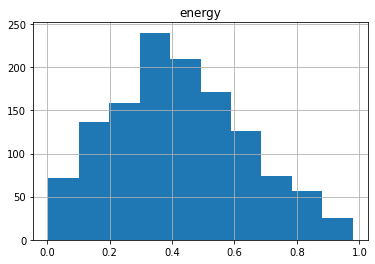

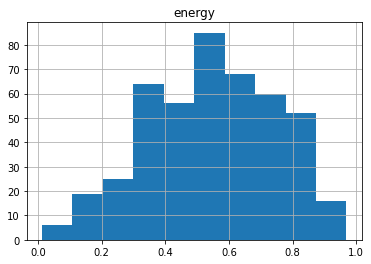

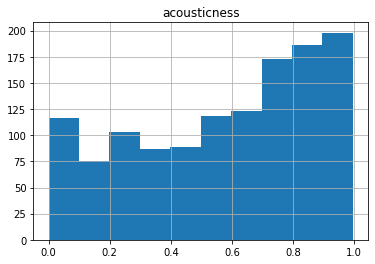

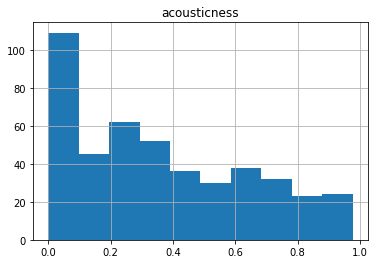

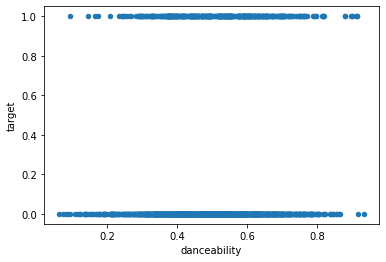

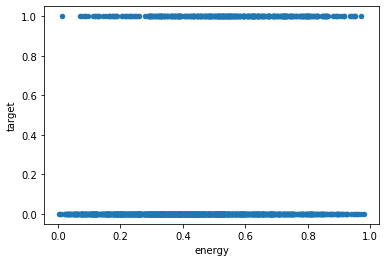

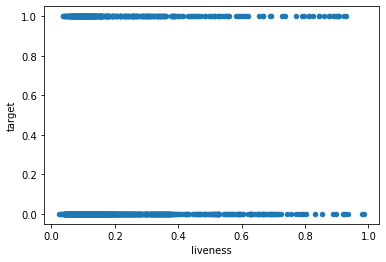

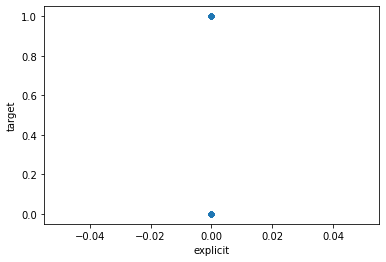

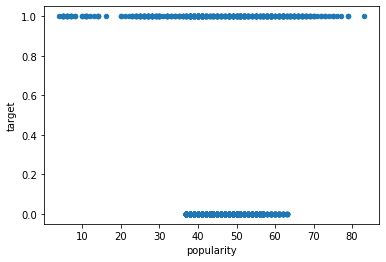

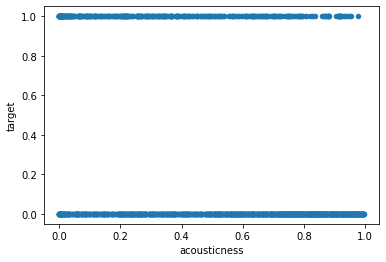

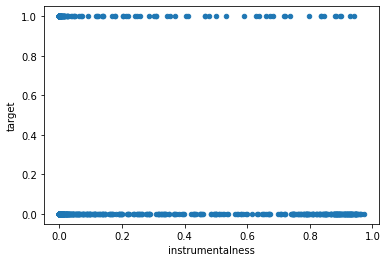

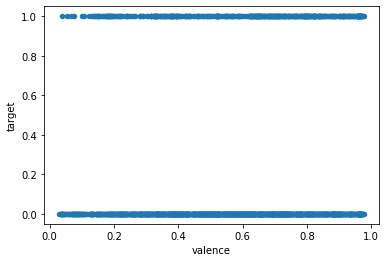

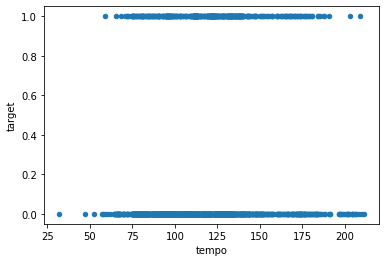

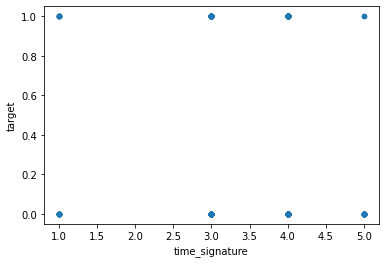

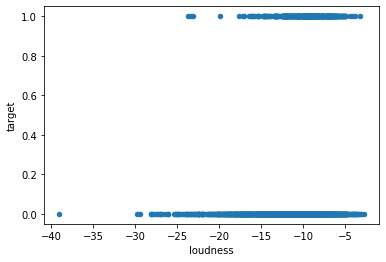

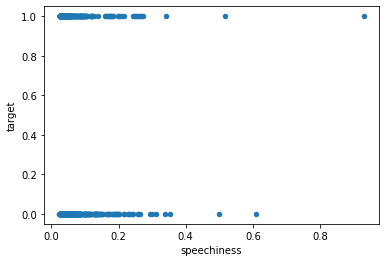

In [282]:
tracks_df['target'] = tracks_df['target'].astype(float)
new_df.hist(column="energy")
beatles.hist(column='energy')
new_df.hist(column="acousticness")
beatles.hist(column='acousticness')
tracks_df.plot('danceability', 'target', 'scatter')
tracks_df.plot('energy', 'target', 'scatter')
tracks_df.plot('liveness', 'target', 'scatter')
tracks_df.plot('explicit', 'target', 'scatter')
tracks_df.plot('popularity', 'target', 'scatter')
tracks_df.plot('acousticness', 'target', 'scatter')
tracks_df.plot('instrumentalness', 'target', 'scatter')
tracks_df.plot('valence', 'target', 'scatter')
tracks_df.plot('tempo', 'target', 'scatter')
tracks_df.plot('time_signature', 'target', 'scatter')
tracks_df.plot('loudness', 'target', 'scatter')
tracks_df.plot('speechiness', 'target', 'scatter')

In [157]:
all_X = tracks_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'release_year', 'duration_ms'])
all_Y = tracks_df['target']
saved_all_X = all_X
all_X

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
36498,0,0.482,0.849,2,-9.198,1,0.0452,0.6410,0.000008,0.0414,0.937,124.631,4
36502,0,0.491,0.801,4,-9.835,1,0.0361,0.2700,0.000000,0.0665,0.971,160.109,4
36503,0,0.520,0.829,0,-6.228,1,0.0806,0.3860,0.000062,0.2270,0.744,147.997,4
36504,0,0.416,0.563,1,-8.724,0,0.0298,0.2070,0.000000,0.3430,0.900,77.560,4
36509,0,0.727,0.338,5,-13.887,1,0.0454,0.7900,0.000000,0.1050,0.646,122.421,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
439956,0,0.562,0.501,1,-15.019,1,0.0334,0.3480,0.000000,0.1320,0.875,127.828,4
465227,0,0.764,0.373,2,-7.176,1,0.0510,0.2490,0.004920,0.0838,0.811,106.704,4
465282,0,0.420,0.430,7,-8.944,1,0.0244,0.0224,0.248000,0.1200,0.337,97.196,4
465283,0,0.592,0.595,5,-4.517,0,0.0297,0.5100,0.000000,0.1060,0.580,106.646,4


### Classification Task with 5-fold Cross Validation

In [162]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test

lgr = LogisticRegression()
nb = BernoulliNB()
knn = KNeighborsClassifier()
svm = LinearSVC()
rf = RandomForestClassifier(max_depth=6)
df = DecisionTreeClassifier(max_depth=6)

models = [lgr, nb, knn, svm, rf, df]
names = ['Logistic Regression', 'Naive Bayes', 'k-Neighbors', 'Support Vector Machine', 'Random Forest', 'Decision Tree']

## ignore convergence warning from logistic regression & svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    scores = cross_val_score(model, X_train, Y_train, cv=5)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)
    print("%0.4f train accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X_test, Y_test, cv=5)
    print("%0.4f test accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print(name + " Recall:", metrics.recall_score(Y_test, pred))
    print(name + " Precision:", metrics.precision_score(Y_test, pred))
    print(name + " F1 Score:", metrics.f1_score(Y_test, pred))
    print()

Logistic Regression Train Accuracy: 0.7643636363636364
[[971  44]
 [280  80]]
Logistic Regression Test Accuracy: 0.7645348837209303
[[236  17]
 [ 64  27]]
0.7535 train accuracy with a standard deviation of 0.01
0.7530 test accuracy with a standard deviation of 0.02
Logistic Regression Recall: 0.2967032967032967
Logistic Regression Precision: 0.6136363636363636
Logistic Regression F1 Score: 0.4

Naive Bayes Train Accuracy: 0.7447272727272727
[[999  16]
 [335  25]]
Naive Bayes Test Accuracy: 0.7238372093023255
[[244   9]
 [ 86   5]]
0.7447 train accuracy with a standard deviation of 0.01
0.7355 test accuracy with a standard deviation of 0.01
Naive Bayes Recall: 0.054945054945054944
Naive Bayes Precision: 0.35714285714285715
Naive Bayes F1 Score: 0.09523809523809525

k-Neighbors Train Accuracy: 0.8189090909090909
[[931  84]
 [165 195]]
k-Neighbors Test Accuracy: 0.7267441860465116
[[210  43]
 [ 51  40]]
0.7345 train accuracy with a standard deviation of 0.02
0.7413 test accuracy with a st

### Plot ROC Curve

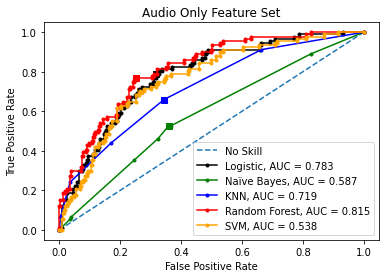

In [189]:
from matplotlib import pyplot

yhat = lgr.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

yhat1 = nb.predict_proba(X_test)
yhat1 = yhat1[:, 1]

yhat2 = knn.predict_proba(X_test)
yhat2 = yhat2[:, 1]

yhat3 = rf.predict_proba(X_test)
yhat3 = yhat3[:, 1]

auc = metrics.roc_auc_score(Y_test, yhat)
auc1 = metrics.roc_auc_score(Y_test, yhat1)
auc2 = metrics.roc_auc_score(Y_test, yhat2)
auc3 = metrics.roc_auc_score(Y_test, yhat3)
auc4 = metrics.roc_auc_score(Y_test, svm.predict(X_test))

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat)
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, yhat1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_test, yhat2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_test, yhat3)
fpr4, tpr4, thresholds4 = metrics.roc_curve((Y_test==1), svm.decision_function(X_test))
    
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
# print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# print('Area under curve: ', auc)

gmeans1 = np.sqrt(tpr1 * (1-fpr1))
ix1 = np.argmax(gmeans1)

gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)

gmeans3 = np.sqrt(tpr3 * (1-fpr3))
ix3 = np.argmax(gmeans3)

gmeans4 = np.sqrt(tpr4 * (1-fpr4))
ix4 = np.argmax(gmeans4)

# 3a, plotting roc curve
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', color='black', label='Logistic, AUC = {:.3f}'.format(auc))
pyplot.plot(fpr1, tpr1, marker='.', color='green', label='Naïve Bayes, AUC = {:.3f}'.format(auc1))
pyplot.plot(fpr2, tpr2, marker='.', color='blue', label='KNN, AUC = {:.3f}'.format(auc2))
pyplot.plot(fpr3, tpr3, marker='.', color='red', label='Random Forest, AUC = {:.3f}'.format(auc3))
pyplot.plot(fpr4, tpr4, marker='.', color='orange', label='SVM, AUC = {:.3f}'.format(auc4))
pyplot.scatter(fpr[ix], tpr[ix], marker='s', color='black')
pyplot.scatter(fpr1[ix1], tpr1[ix1], marker='s', color='green')
pyplot.scatter(fpr2[ix2], tpr2[ix2], marker='s', color='blue')
pyplot.scatter(fpr3[ix3], tpr3[ix3], marker='s', color='red')
pyplot.scatter(fpr4[ix4], tpr4[ix4], marker='s', color='orange')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Audio Only Feature Set')
pyplot.legend()

# show the plot
pyplot.show()

### Plot Decision Tree and Most Important Features

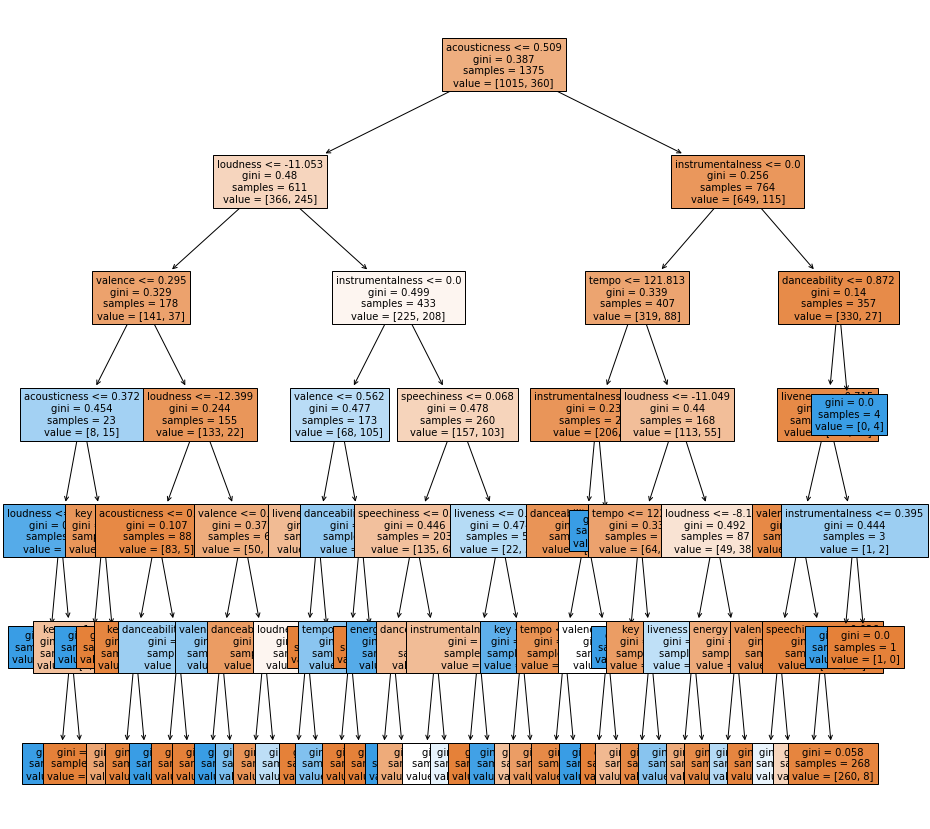

<AxesSubplot:title={'center':'Top Features for Audio Only Classification Task'}>

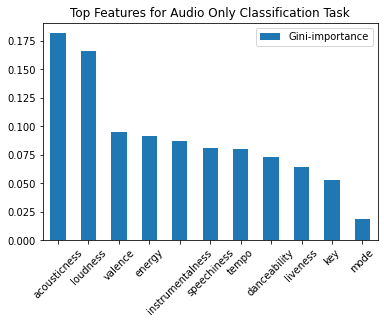

In [190]:
from sklearn import tree

plt.figure(figsize=(15,15))
tree.plot_tree(df, fontsize=10, feature_names=saved_all_X.columns, filled=True)
plt.show()

importances = rf.feature_importances_
importances = importances[:10]
std = np.std([tre.feature_importances_ for tre in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(saved_all_X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
importance = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importance = importance.sort_values(by='Gini-importance', ascending=False)
to_drop = importance[importance['Gini-importance'] < 0.01]
importance = importance.drop(index=to_drop.index, inplace=False)
importance.plot(kind='bar', rot=45, title='Top Features for Audio Only Classification Task')
# importance.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

# Classification on Lyrics Only Feature Set
### Feature Selection on Lyrics Features

In [220]:
all_X = lyrics_bag_df.drop(columns=['target', 'name'])
all_Y = lyrics_bag_df['target']

from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold = 0.25)
saved_all_X = all_X
all_X = sel.fit_transform(all_X)
all_X.shape

(1719, 5262)

### Classification Task with 5-fold cross-validation

In [221]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test

lgr = LogisticRegression()
nb = BernoulliNB()
knn = KNeighborsClassifier()
svm = LinearSVC()
rf = RandomForestClassifier(max_depth=6)
df = DecisionTreeClassifier(max_depth=6)

models = [lgr, nb, knn, svm, rf, df]
names = ['Logistic Regression', 'Naive Bayes', 'k-Neighbors', 'Support Vector Machine', 'Random Forest', 'Decision Tree']

## ignore convergence warning from logistic regression & svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    scores = cross_val_score(model, X_train, Y_train, cv=5)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)
    print("%0.4f train accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X_test, Y_test, cv=5)
    print("%0.4f test accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print(name + " Recall:", metrics.recall_score(Y_test, pred))
    print(name + " Precision:", metrics.precision_score(Y_test, pred))
    print(name + " F1 Score:", metrics.f1_score(Y_test, pred))
    print()

Logistic Regression Train Accuracy: 0.9338181818181818
[[1009    8]
 [  83  275]]
Logistic Regression Test Accuracy: 0.9186046511627907
[[249   2]
 [ 26  67]]
0.9193 train accuracy with a standard deviation of 0.01
0.8926 test accuracy with a standard deviation of 0.05
Logistic Regression Recall: 0.7204301075268817
Logistic Regression Precision: 0.9710144927536232
Logistic Regression F1 Score: 0.8271604938271604

Naive Bayes Train Accuracy: 0.8094545454545454
[[936  81]
 [181 177]]
Naive Bayes Test Accuracy: 0.7965116279069767
[[229  22]
 [ 48  45]]
0.8065 train accuracy with a standard deviation of 0.02
0.7937 test accuracy with a standard deviation of 0.04
Naive Bayes Recall: 0.4838709677419355
Naive Bayes Precision: 0.6716417910447762
Naive Bayes F1 Score: 0.5625000000000001

k-Neighbors Train Accuracy: 0.9185454545454546
[[1000   17]
 [  95  263]]
k-Neighbors Test Accuracy: 0.8662790697674418
[[235  16]
 [ 30  63]]
0.8895 train accuracy with a standard deviation of 0.02
0.8228 test

### Plot ROC Curve

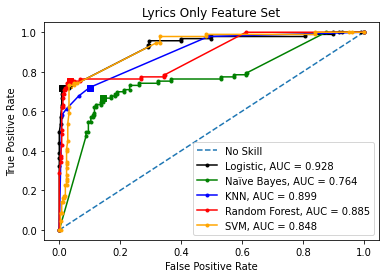

In [222]:
from matplotlib import pyplot

yhat = lgr.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

yhat1 = nb.predict_proba(X_test)
yhat1 = yhat1[:, 1]

yhat2 = knn.predict_proba(X_test)
yhat2 = yhat2[:, 1]

yhat3 = rf.predict_proba(X_test)
yhat3 = yhat3[:, 1]

auc = metrics.roc_auc_score(Y_test, yhat)
auc1 = metrics.roc_auc_score(Y_test, yhat1)
auc2 = metrics.roc_auc_score(Y_test, yhat2)
auc3 = metrics.roc_auc_score(Y_test, yhat3)
auc4 = metrics.roc_auc_score(Y_test, svm.predict(X_test))

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat)
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, yhat1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_test, yhat2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_test, yhat3)
fpr4, tpr4, thresholds4 = metrics.roc_curve((Y_test==1), svm.decision_function(X_test))
    
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
# print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# print('Area under curve: ', auc)

gmeans1 = np.sqrt(tpr1 * (1-fpr1))
ix1 = np.argmax(gmeans1)

gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)

gmeans3 = np.sqrt(tpr3 * (1-fpr3))
ix3 = np.argmax(gmeans3)

gmeans4 = np.sqrt(tpr4 * (1-fpr4))
ix4 = np.argmax(gmeans4)

# 3a, plotting roc curve
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', color='black', label='Logistic, AUC = {:.3f}'.format(auc))
pyplot.plot(fpr1, tpr1, marker='.', color='green', label='Naïve Bayes, AUC = {:.3f}'.format(auc1))
pyplot.plot(fpr2, tpr2, marker='.', color='blue', label='KNN, AUC = {:.3f}'.format(auc2))
pyplot.plot(fpr3, tpr3, marker='.', color='red', label='Random Forest, AUC = {:.3f}'.format(auc3))
pyplot.plot(fpr4, tpr4, marker='.', color='orange', label='SVM, AUC = {:.3f}'.format(auc4))
pyplot.scatter(fpr[ix], tpr[ix], marker='s', color='black')
pyplot.scatter(fpr1[ix1], tpr1[ix1], marker='s', color='green')
pyplot.scatter(fpr2[ix2], tpr2[ix2], marker='s', color='blue')
pyplot.scatter(fpr3[ix3], tpr3[ix3], marker='s', color='red')
pyplot.scatter(fpr4[ix4], tpr4[ix4], marker='s', color='orange')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Lyrics Only Feature Set')
pyplot.legend()

# show the plot
pyplot.show()

### Plot decision tree and most important features

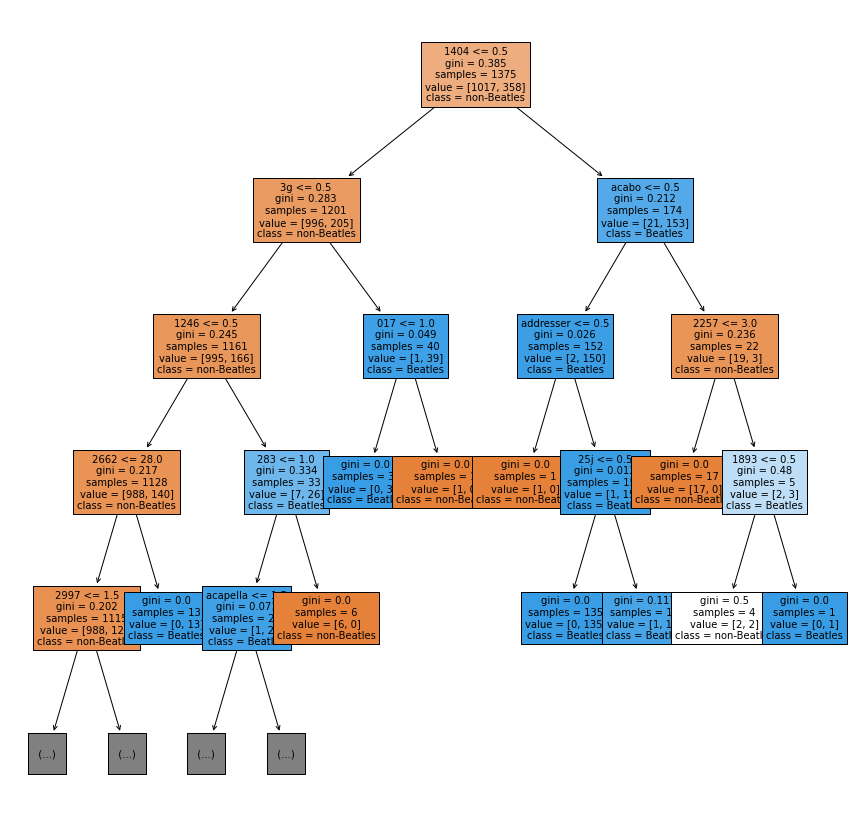

<AxesSubplot:title={'center':'Top Features for Lyrics Only Classification Task'}>

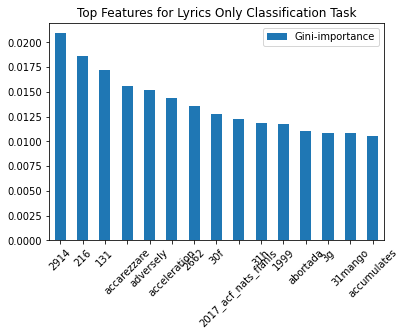

In [224]:
from sklearn import tree

plt.figure(figsize=(15,15))
tree.plot_tree(df, fontsize=10, feature_names=saved_all_X.columns, filled=True, class_names=['non-Beatles', 'Beatles'], max_depth=4)
plt.show()

importances = rf.feature_importances_
importances = importances[:10]
std = np.std([tre.feature_importances_ for tre in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(saved_all_X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
importance = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importance = importance.sort_values(by='Gini-importance', ascending=False)
to_drop = importance[importance['Gini-importance'] < 0.01]
importance = importance.drop(index=to_drop.index, inplace=False)
importance.plot(kind='bar', rot=45, title='Top Features for Lyrics Only Classification Task')
# importance.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

# Classification on Combined Feature Set
### Feature Selection on Combined Feature Set

In [197]:
all_X = combined_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'release_year', 'duration_ms'])
all_Y = combined_df['target']

from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold = 0.25)
saved_all_X = all_X
all_X = sel.fit_transform(all_X)
all_X.shape

(1719, 5383)

### Classification Task with 5-fold Cross Validation

In [218]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test

lgr = LogisticRegression()
nb = BernoulliNB()
knn = KNeighborsClassifier()
svm = LinearSVC()
rf = RandomForestClassifier(max_depth=6)
df = DecisionTreeClassifier(max_depth=6)

models = [lgr, nb, knn, svm, rf, df]
names = ['Logistic Regression', 'Naive Bayes', 'k-Neighbors', 'Support Vector Machine', 'Random Forest', 'Decision Tree']

## ignore convergence warning from logistic regression & svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    scores = cross_val_score(model, X_train, Y_train, cv=5)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)
    print("%0.4f train accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X_test, Y_test, cv=5)
    print("%0.4f test accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print(name + " Recall:", metrics.recall_score(Y_test, pred))
    print(name + " Precision:", metrics.precision_score(Y_test, pred))
    print(name + " F1 Score:", metrics.f1_score(Y_test, pred))
    print()

Logistic Regression Train Accuracy: 0.9287272727272727
[[1002   16]
 [  82  275]]
Logistic Regression Test Accuracy: 0.9186046511627907
[[241   9]
 [ 19  75]]
0.9076 train accuracy with a standard deviation of 0.01
0.8838 test accuracy with a standard deviation of 0.01
Logistic Regression Recall: 0.7978723404255319
Logistic Regression Precision: 0.8928571428571429
Logistic Regression F1 Score: 0.8426966292134832

Naive Bayes Train Accuracy: 0.7985454545454546
[[928  90]
 [187 170]]
Naive Bayes Test Accuracy: 0.8255813953488372
[[232  18]
 [ 42  52]]
0.7978 train accuracy with a standard deviation of 0.02
0.8256 test accuracy with a standard deviation of 0.01
Naive Bayes Recall: 0.5531914893617021
Naive Bayes Precision: 0.7428571428571429
Naive Bayes F1 Score: 0.6341463414634146

k-Neighbors Train Accuracy: 0.9178181818181819
[[968  50]
 [ 63 294]]
k-Neighbors Test Accuracy: 0.8662790697674418
[[233  17]
 [ 29  65]]
0.8647 train accuracy with a standard deviation of 0.02
0.7965 test acc

### Plot ROC Curve

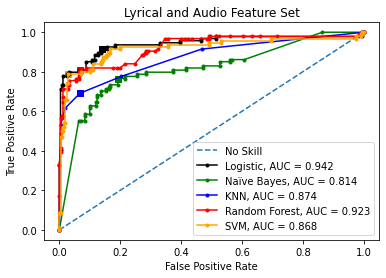

In [219]:
from matplotlib import pyplot

yhat = lgr.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

yhat1 = nb.predict_proba(X_test)
yhat1 = yhat1[:, 1]

yhat2 = knn.predict_proba(X_test)
yhat2 = yhat2[:, 1]

yhat3 = rf.predict_proba(X_test)
yhat3 = yhat3[:, 1]

auc = metrics.roc_auc_score(Y_test, yhat)
auc1 = metrics.roc_auc_score(Y_test, yhat1)
auc2 = metrics.roc_auc_score(Y_test, yhat2)
auc3 = metrics.roc_auc_score(Y_test, yhat3)
auc4 = metrics.roc_auc_score(Y_test, svm.predict(X_test))

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat)
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, yhat1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_test, yhat2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_test, yhat3)
fpr4, tpr4, thresholds4 = metrics.roc_curve((Y_test==1), svm.decision_function(X_test))
    
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
# print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# print('Area under curve: ', auc)

gmeans1 = np.sqrt(tpr1 * (1-fpr1))
ix1 = np.argmax(gmeans1)

gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)

gmeans3 = np.sqrt(tpr3 * (1-fpr3))
ix3 = np.argmax(gmeans3)

gmeans4 = np.sqrt(tpr4 * (1-fpr4))
ix4 = np.argmax(gmeans4)

# 3a, plotting roc curve
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', color='black', label='Logistic, AUC = {:.3f}'.format(auc))
pyplot.plot(fpr1, tpr1, marker='.', color='green', label='Naïve Bayes, AUC = {:.3f}'.format(auc1))
pyplot.plot(fpr2, tpr2, marker='.', color='blue', label='KNN, AUC = {:.3f}'.format(auc2))
pyplot.plot(fpr3, tpr3, marker='.', color='red', label='Random Forest, AUC = {:.3f}'.format(auc3))
pyplot.plot(fpr4, tpr4, marker='.', color='orange', label='SVM, AUC = {:.3f}'.format(auc4))
pyplot.scatter(fpr[ix], tpr[ix], marker='s', color='black')
pyplot.scatter(fpr1[ix1], tpr1[ix1], marker='s', color='green')
pyplot.scatter(fpr2[ix2], tpr2[ix2], marker='s', color='blue')
pyplot.scatter(fpr3[ix3], tpr3[ix3], marker='s', color='red')
pyplot.scatter(fpr4[ix4], tpr4[ix4], marker='s', color='orange')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Lyrical and Audio Feature Set')
pyplot.legend()

# show the plot
pyplot.show()

### Plot Decision Tree and Most Important Features

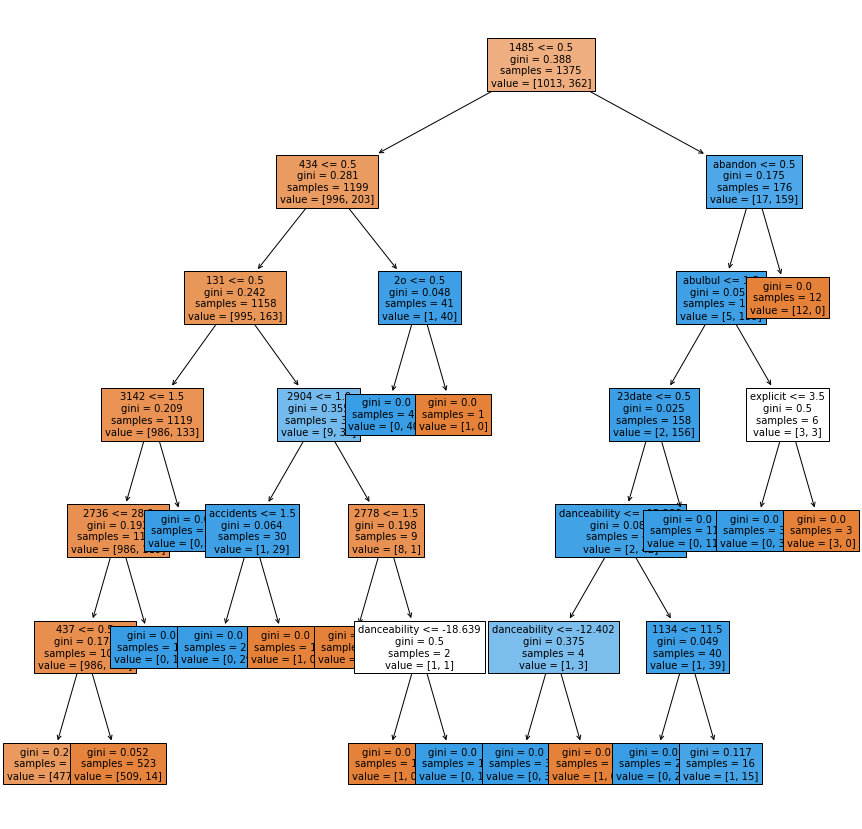

<AxesSubplot:title={'center':'Top Features for Combined Features Classification Task'}>

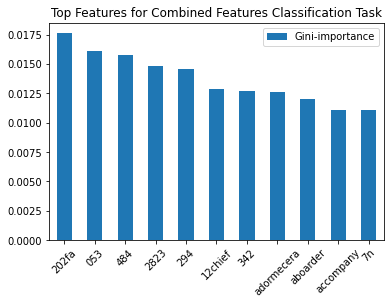

In [147]:
from sklearn import tree

plt.figure(figsize=(15,15))
tree.plot_tree(df, fontsize=10, feature_names=saved_all_X.columns, filled=True)
plt.show()

importances = rf.feature_importances_
importances = importances[:10]
std = np.std([tre.feature_importances_ for tre in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(saved_all_X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
importance = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importance = importance.sort_values(by='Gini-importance', ascending=False)
to_drop = importance[importance['Gini-importance'] < 0.011]
importance = importance.drop(index=to_drop.index, inplace=False)
importance.plot(kind='bar', rot=45, title='Top Features for Combined Features Classification Task')
# importance.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

# IGNORE ALL CELLS BELOW THIS POINT, this was code that I wrote for my other project ideas (predicting Billie Eilish songs, predicting popularity, time series analysis of popularity) that I did not end up using! Thank you!

### Classification Task WITHOUT Feature Selection

In [261]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

all_X = tracks_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'release_year', 'duration_ms', 'followers'])
all_Y = tracks_df['target']

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test

lgr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()
svm = LinearSVC()
rf = RandomForestClassifier(max_depth=6)
df = DecisionTreeClassifier(max_depth=6)

models = [lgr, nb, knn, svm, rf, df]
names = ['Logistic Regression', 'Naive Bayes', 'k-Neighbors', 'Support Vector Machine', 'Random Forest', 'Decision Tree']

## ignore convergence warning from logistic regression & svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)

Logistic Regression Train Accuracy: 0.7563636363636363
[[954  56]
 [279  86]]
Logistic Regression Test Accuracy: 0.7558139534883721
[[236  22]
 [ 62  24]]
Naive Bayes Train Accuracy: 0.7112727272727273
[[756 254]
 [143 222]]
Naive Bayes Test Accuracy: 0.7296511627906976
[[192  66]
 [ 27  59]]
k-Neighbors Train Accuracy: 0.8123636363636364
[[925  85]
 [173 192]]
k-Neighbors Test Accuracy: 0.7674418604651163
[[221  37]
 [ 43  43]]
Support Vector Machine Train Accuracy: 0.7345454545454545
[[1010    0]
 [ 365    0]]
Support Vector Machine Test Accuracy: 0.75
[[258   0]
 [ 86   0]]
Random Forest Train Accuracy: 0.850909090909091
[[1001    9]
 [ 196  169]]
Random Forest Test Accuracy: 0.8023255813953488
[[250   8]
 [ 60  26]]
Decision Tree Train Accuracy: 0.8312727272727273
[[959  51]
 [181 184]]
Decision Tree Test Accuracy: 0.747093023255814
[[229  29]
 [ 58  28]]


### Plot Decision Tree and Most Important Features

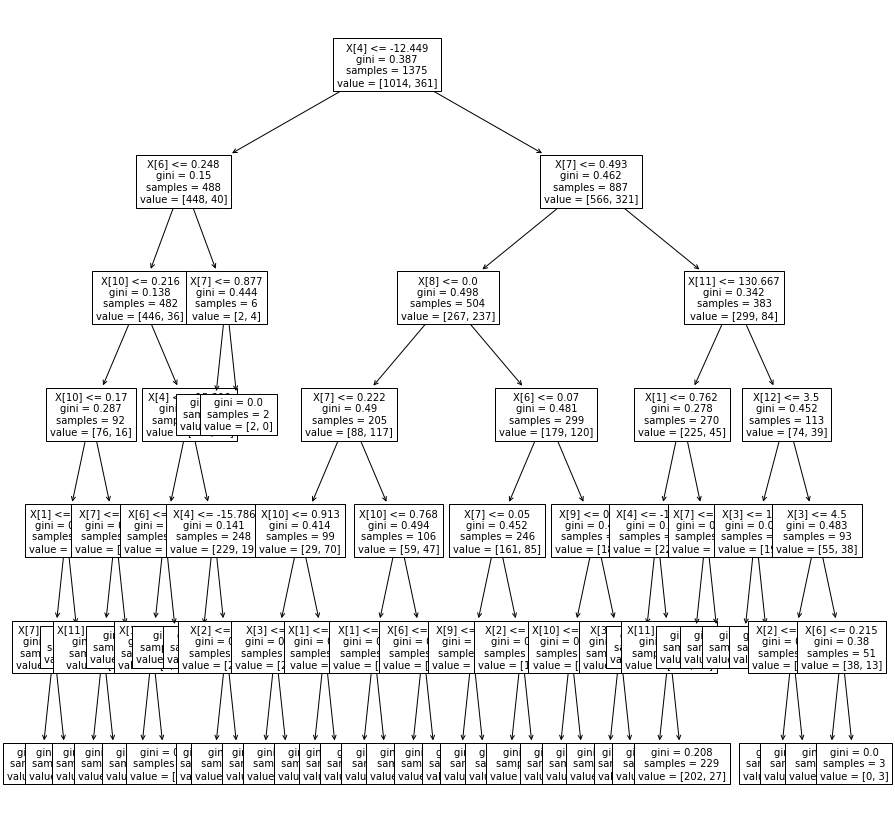

In [240]:
from sklearn import tree

plt.figure(figsize=(15,15))
tree.plot_tree(df, fontsize=10)
plt.show()

<AxesSubplot:>

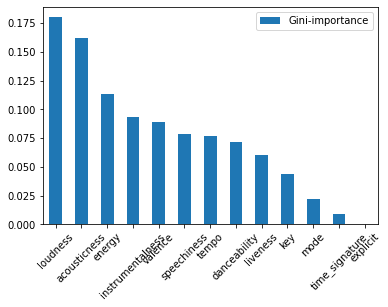

In [262]:
importances = rf.feature_importances_
std = np.std([tre.feature_importances_ for tre in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(all_X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
importance = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importance.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

### Classification Task WITH Feature Selection

In [242]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold = 0.07)
saved_all_X = all_X
all_X = sel.fit_transform(all_X)
all_X.shape

(1719, 7)

In [272]:
from sklearn.model_selection import cross_val_score

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test

lgr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()
svm = LinearSVC()
rf = RandomForestClassifier(max_depth=6)
df = DecisionTreeClassifier(max_depth=6)

models = [lgr, nb, knn, svm, rf, df]
names = ['Logistic Regression', 'Naive Bayes', 'k-Neighbors', 'Support Vector Machine', 'Random Forest', 'Decision Tree']

## ignore convergence warning from logistic regression & svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    scores = cross_val_score(model, X_train, Y_train, cv=5)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)
    print("%0.4f train accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X_test, Y_test, cv=5)
    print("%0.4f test accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print(name + " Recall:", metrics.recall_score(Y_test, pred))
    print(name + " Precision:", metrics.precision_score(Y_test, pred))
    print(name + " F1 Score:", metrics.f1_score(Y_test, pred))
    print()

Logistic Regression Train Accuracy: 0.7607272727272727
[[958  56]
 [273  88]]
Logistic Regression Test Accuracy: 0.752906976744186
[[238  16]
 [ 69  21]]
0.7513 train accuracy with a standard deviation of 0.03
0.7384 test accuracy with a standard deviation of 0.05
Logistic Regression Recall: 0.23333333333333334
Logistic Regression Precision: 0.5675675675675675
Logistic Regression F1 Score: 0.33070866141732286

Naive Bayes Train Accuracy: 0.7149090909090909
[[753 261]
 [131 230]]
Naive Bayes Test Accuracy: 0.6802325581395349
[[178  76]
 [ 34  56]]
0.7105 train accuracy with a standard deviation of 0.03
0.6831 test accuracy with a standard deviation of 0.04
Naive Bayes Recall: 0.6222222222222222
Naive Bayes Precision: 0.42424242424242425
Naive Bayes F1 Score: 0.5045045045045045

k-Neighbors Train Accuracy: 0.824
[[938  76]
 [166 195]]
k-Neighbors Test Accuracy: 0.7063953488372093
[[214  40]
 [ 61  29]]
0.7389 train accuracy with a standard deviation of 0.02
0.7644 test accuracy with a st

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Train Accuracy: 0.8472727272727273
[[1005    9]
 [ 201  160]]
Random Forest Test Accuracy: 0.7965116279069767
[[247   7]
 [ 63  27]]
0.7731 train accuracy with a standard deviation of 0.02
0.7732 test accuracy with a standard deviation of 0.02
Random Forest Recall: 0.3
Random Forest Precision: 0.7941176470588235
Random Forest F1 Score: 0.43548387096774194

Decision Tree Train Accuracy: 0.8305454545454546
[[965  49]
 [184 177]]
Decision Tree Test Accuracy: 0.7645348837209303
[[226  28]
 [ 53  37]]
0.7498 train accuracy with a standard deviation of 0.02
0.7209 test accuracy with a standard deviation of 0.02
Decision Tree Recall: 0.4111111111111111
Decision Tree Precision: 0.5692307692307692
Decision Tree F1 Score: 0.4774193548387097



<AxesSubplot:>

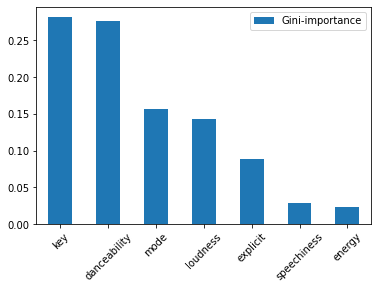

In [244]:
importances = rf.feature_importances_
std = np.std([tre.feature_importances_ for tre in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(saved_all_X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
importance = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importance.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

### Classification Task including Artist Features

In [256]:
tracks_df['followers'] = tracks_df['followers'].fillna(0)
all_X = tracks_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'release_year', 'duration_ms'])
all_Y = tracks_df['target']

sel = VarianceThreshold(threshold = 0.07)
saved_all_X = all_X
all_X = sel.fit_transform(all_X)
print(all_X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test

lgr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()
svm = LinearSVC()
rf = RandomForestClassifier(max_depth=6)
df = DecisionTreeClassifier(max_depth=6)

models = [lgr, nb, knn, svm, rf, df]
names = ['Logistic Regression', 'Naive Bayes', 'k-Neighbors', 'Support Vector Machine', 'Random Forest', 'Decision Tree']

## ignore convergence warning from logistic regression & svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)

(1719, 8)
Logistic Regression Train Accuracy: 0.2676363636363636
[[   0 1007]
 [   0  368]]
Logistic Regression Test Accuracy: 0.2441860465116279
[[  1 260]
 [  0  83]]
Naive Bayes Train Accuracy: 0.9949090909090909
[[1003    4]
 [   3  365]]
Naive Bayes Test Accuracy: 0.9883720930232558
[[257   4]
 [  0  83]]
k-Neighbors Train Accuracy: 0.9992727272727273
[[1006    1]
 [   0  368]]
k-Neighbors Test Accuracy: 0.997093023255814
[[260   1]
 [  0  83]]
Support Vector Machine Train Accuracy: 0.9956363636363637
[[1004    3]
 [   3  365]]
Support Vector Machine Test Accuracy: 0.9912790697674418
[[258   3]
 [  0  83]]
Random Forest Train Accuracy: 0.9985454545454545
[[1007    0]
 [   2  366]]
Random Forest Test Accuracy: 1.0
[[261   0]
 [  0  83]]
Decision Tree Train Accuracy: 1.0
[[1007    0]
 [   0  368]]
Decision Tree Test Accuracy: 1.0
[[261   0]
 [  0  83]]


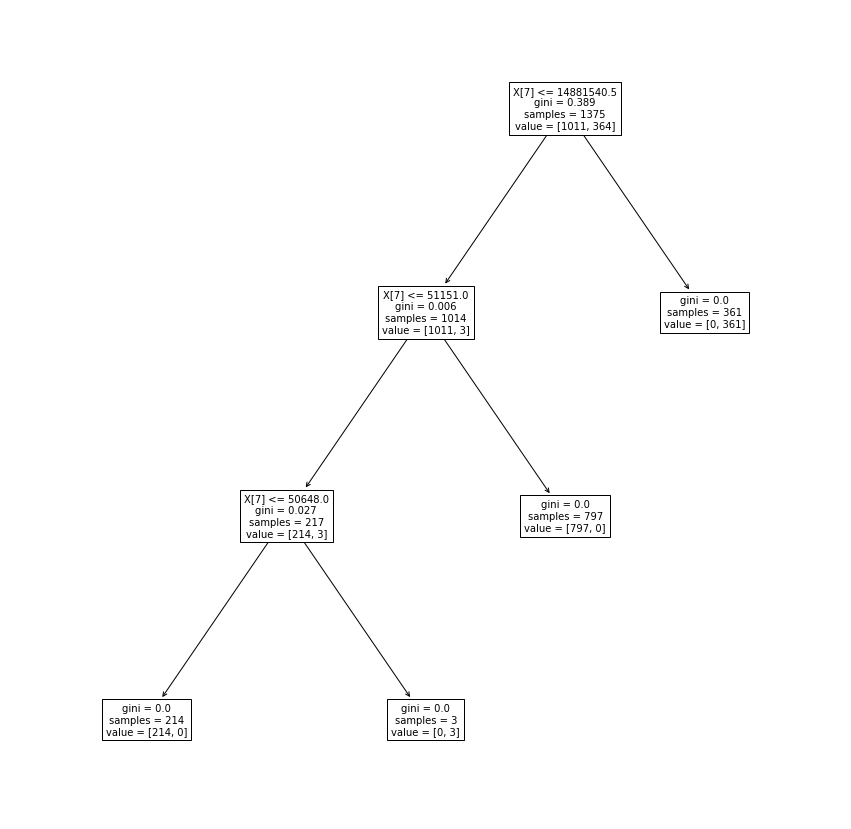

In [252]:
from sklearn import tree

plt.figure(figsize=(15,15))
tree.plot_tree(df, fontsize=10)
plt.show()

<AxesSubplot:>

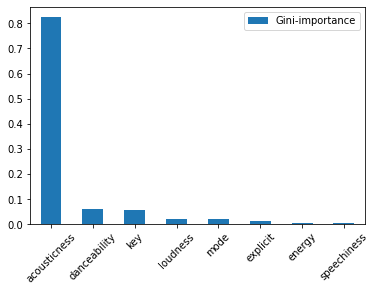

In [255]:
importances = rf.feature_importances_
std = np.std([tre.feature_importances_ for tre in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(saved_all_X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
importance = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importance.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

# START HERE

In [103]:
tracks_df = pd.read_csv('new_tracks.csv')
artists_df = pd.read_csv('artists.csv')
tracks_df['artist_popularity'] = 0

tracks_df.reset_index(drop=True, inplace=True)
artists_df.reset_index(drop=True, inplace=True)

for i in tracks_df.index:
    ids = tracks_df.iloc[i]['id_artists']
    all_ids = ids.split()
    numFollowers = 0
    for thing in all_ids: 
        idx = artists_df[artists_df['id'] == thing]
        if len(idx) > 0: 
            # print(artists_df.loc[idx.index]['followers'])
            if np.isnan(artists_df.loc[idx.index]['popularity']).bool():
                print('is nan')
            else:
                numFollowers = numFollowers + int(artists_df.loc[idx.index]['popularity'])
    tracks_df.at[i, 'artist_popularity'] = numFollowers
    


## Using 2019 to predict 2020

In [76]:
train_index = tracks_df[tracks_df['release_year'] != 2019]
test_index = tracks_df[tracks_df['release_year'] != 2020]

# print(too_old.index)
train_df = tracks_df.drop(index=train_index.index, inplace=False)

test_df = tracks_df.drop(index=test_index.index, inplace=False)
test_df

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,target,release_year,followers
0,6Pkt6qVikqPBt9bEQy8iTz,A Lovers Concerto,41,159560,0,The Toys,6lH5PpuiMa5SpfjoIOlwCS,3/13/20,0.671,0.8670,...,0.0571,0.436,0.000000,0.1390,0.8390,120.689,4,False,2020,0
1,55qyghODi24yaDgKBI6lx0,The Circle Game - Live at The 2nd Fret Philade...,18,313093,0,Joni Mitchell,5hW4L92KnC6dX9t7tYM4Ve,10/30/20,0.644,0.2120,...,0.0347,0.881,0.000022,0.7980,0.4410,117.072,3,False,2020,971124
2,00xemFYjQNRpOlPhVaLAHa,Urge For Going - Live at The 2nd Fret Philadel...,18,295093,0,Joni Mitchell,5hW4L92KnC6dX9t7tYM4Ve,10/30/20,0.627,0.1840,...,0.0450,0.955,0.000162,0.0986,0.2990,115.864,4,False,2020,971124
3,26g4FBGTB9YEj7q4HlblFf,Brandy Eyes - Live at The 2nd Fret Philadelphi...,17,147907,0,Joni Mitchell,5hW4L92KnC6dX9t7tYM4Ve,10/30/20,0.442,0.3990,...,0.0780,0.930,0.000499,0.9120,0.5540,121.662,4,False,2020,971124
4,2lm5FQJRHvc3rUN5YHpEWj,Whats The Story Mr. Blue - Live at The 2nd Fre...,17,183440,0,Joni Mitchell,5hW4L92KnC6dX9t7tYM4Ve,10/30/20,0.581,0.3310,...,0.2430,0.888,0.000015,0.1470,0.6420,88.303,4,False,2020,971124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32119,0SjsIzJkZfDU7wlcdklEFR,John Browns Song,66,185250,0,Gregory Oberle,4MxqhahGRT4BPz1PilXGeu,3/20/20,0.562,0.0331,...,0.1030,0.996,0.961000,0.1110,0.3860,63.696,3,True,2020,91
32120,1ZwZsVZUiyFwIHMNpI3ERt,Skyscraper,4,106002,0,Emilie Chin,4USdOnfLczwUglA3TrdHs2,2/8/20,0.626,0.5300,...,0.0284,0.113,0.856000,0.1040,0.2150,120.113,4,False,2020,0
32121,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,阿YueYue,1QLBXKM5GCpyQQSVMNZqrZ,9/26/20,0.560,0.5180,...,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,False,2020,896
32122,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,ROLE MODEL,1dy5WNgIKQU6ezkpZs4y8z,10/21/20,0.765,0.6630,...,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,True,2020,245944


# Exploratory Data Analysis

<AxesSubplot:xlabel='speechiness', ylabel='target'>

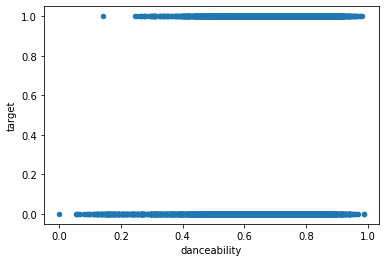

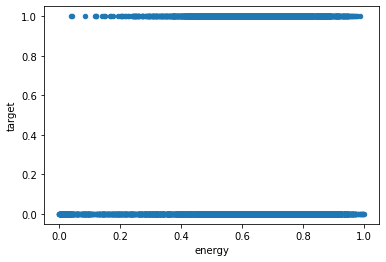

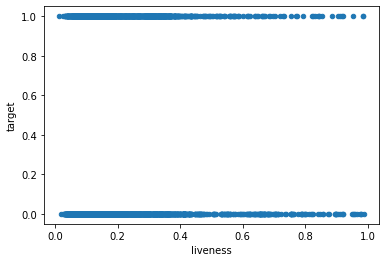

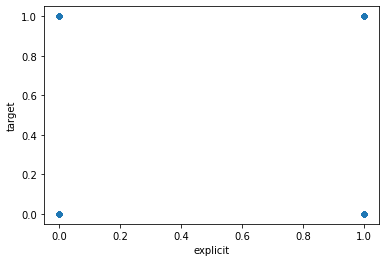

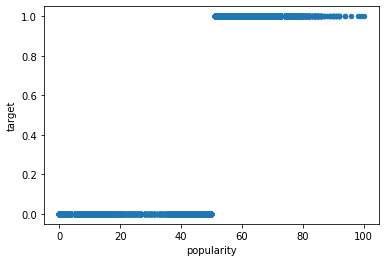

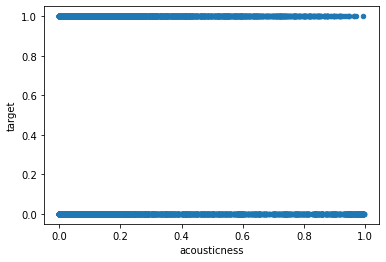

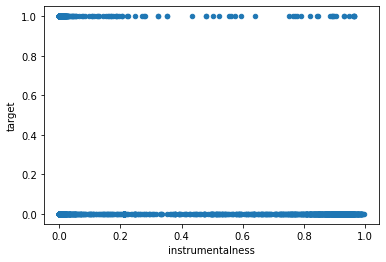

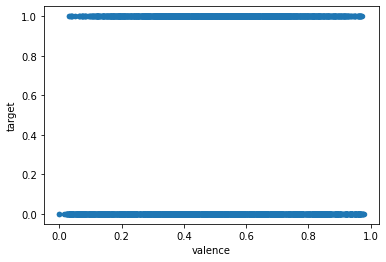

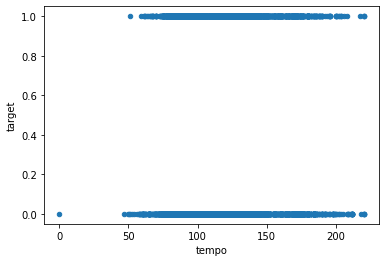

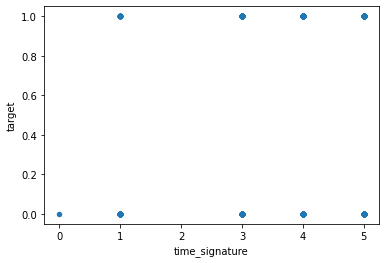

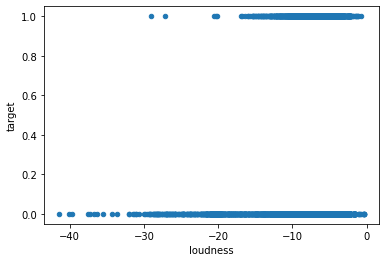

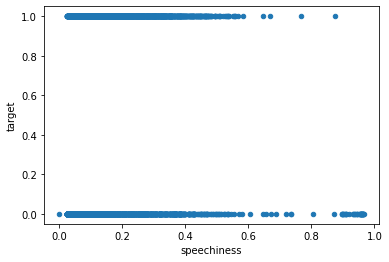

In [25]:
test_df['target'] = test_df['target'].astype(float)
test_df.plot('danceability', 'target', 'scatter')
test_df.plot('energy', 'target', 'scatter')
test_df.plot('liveness', 'target', 'scatter')
test_df.plot('explicit', 'target', 'scatter')
test_df.plot('popularity', 'target', 'scatter')
test_df.plot('acousticness', 'target', 'scatter')
test_df.plot('instrumentalness', 'target', 'scatter')
test_df.plot('valence', 'target', 'scatter')
test_df.plot('tempo', 'target', 'scatter')
test_df.plot('time_signature', 'target', 'scatter')
test_df.plot('loudness', 'target', 'scatter')
test_df.plot('speechiness', 'target', 'scatter')
# plt.scatter(tracks_df.loc[:,'danceability'], tracks_df.loc[:,'target'])
# plt.scatter(tracks_df.loc[:,'energy'], tracks_df.loc[:,'target'])
# plt.scatter(tracks_df.loc[:,'liveness'], tracks_df.loc[:,'target'])

# Feature Selection

In [56]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold = 0.05)
all_X = train_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'followers'])
all_Y = train_df['target']
all_X = sel.fit_transform(all_X)
all_X.shape

(11907, 10)

# Classification without artist features

In [57]:
from sklearn.linear_model import LogisticRegression

## ignore convergence warning from logistic regression & svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test
logisticRegr.fit(x_train, y_train)

# Returns a NumPy Array
# Predict for One Observation (image)
predictions = logisticRegr.predict(x_test)

# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)
test_cm = metrics.confusion_matrix(Y_test, predictions)
print(test_cm)

test_features = test_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'followers'])
test_X = sel.transform(test_features)
test_Y = test_df['target']
test_predictions = logisticRegr.predict(test_X)
test_score = logisticRegr.score(test_X, test_Y)
print(test_score)
test_matrix = metrics.confusion_matrix(test_Y, test_predictions)
print(test_matrix)

0.5247691015952981
[[883 359]
 [773 367]]
0.5021166678625242
[[4388 2354]
 [4585 2610]]


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

lgr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()
svm = LinearSVC()
rf = RandomForestClassifier()
df = DecisionTreeClassifier()

models = [lgr, nb, knn, svm, rf, df]
names = ['Logistic Regression', 'Naive Bayes', 'k-Neighbors', 'Support Vector Machine', 'Random Forest', 'Decision Tree']

## ignore convergence warning from logistic regression & svm
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)

Logistic Regression Train Accuracy: 0.5137007874015748
[[3488 1404]
 [3228 1405]]
Logistic Regression Test Accuracy: 0.5247691015952981
[[883 359]
 [773 367]]
Naive Bayes Train Accuracy: 0.5541207349081365
[[1018 3874]
 [ 373 4260]]
Naive Bayes Test Accuracy: 0.5499580184718724
[[ 268  974]
 [  98 1042]]
k-Neighbors Train Accuracy: 0.7145406824146981
[[3562 1330]
 [1389 3244]]
k-Neighbors Test Accuracy: 0.552896725440806
[[710 532]
 [533 607]]
Support Vector Machine Train Accuracy: 0.4974278215223097
[[ 114 4778]
 [   9 4624]]
Support Vector Machine Test Accuracy: 0.48866498740554154
[[  24 1218]
 [   0 1140]]
Random Forest Train Accuracy: 0.996745406824147
[[4873   19]
 [  12 4621]]
Random Forest Test Accuracy: 0.6238455079764903
[[727 515]
 [381 759]]
Decision Tree Train Accuracy: 0.996745406824147
[[4889    3]
 [  28 4605]]
Decision Tree Test Accuracy: 0.5877413937867338
[[728 514]
 [468 672]]


## Classification on 2020 Songs

In [65]:
for model, name in zip(models, names):
    pred = model.predict(test_X)
    test_score = model.score(test_X, test_Y)
    print(name + ' Test Accuracy: ', test_score)
    test_matrix = metrics.confusion_matrix(test_Y, pred)
    print(test_matrix)

Logistic Regression Test Accuracy:  0.5021166678625242
[[4388 2354]
 [4585 2610]]
Naive Bayes Test Accuracy:  0.615412212097295
[[1951 4791]
 [ 569 6626]]
k-Neighbors Test Accuracy:  0.5622443854488053
[[3970 2772]
 [3329 3866]]
Support Vector Machine Test Accuracy:  0.5408624524646624
[[ 378 6364]
 [  35 7160]]
Random Forest Test Accuracy:  0.6629116739613977
[[4413 2329]
 [2369 4826]]
Decision Tree Test Accuracy:  0.5879314056109636
[[4186 2556]
 [3187 4008]]


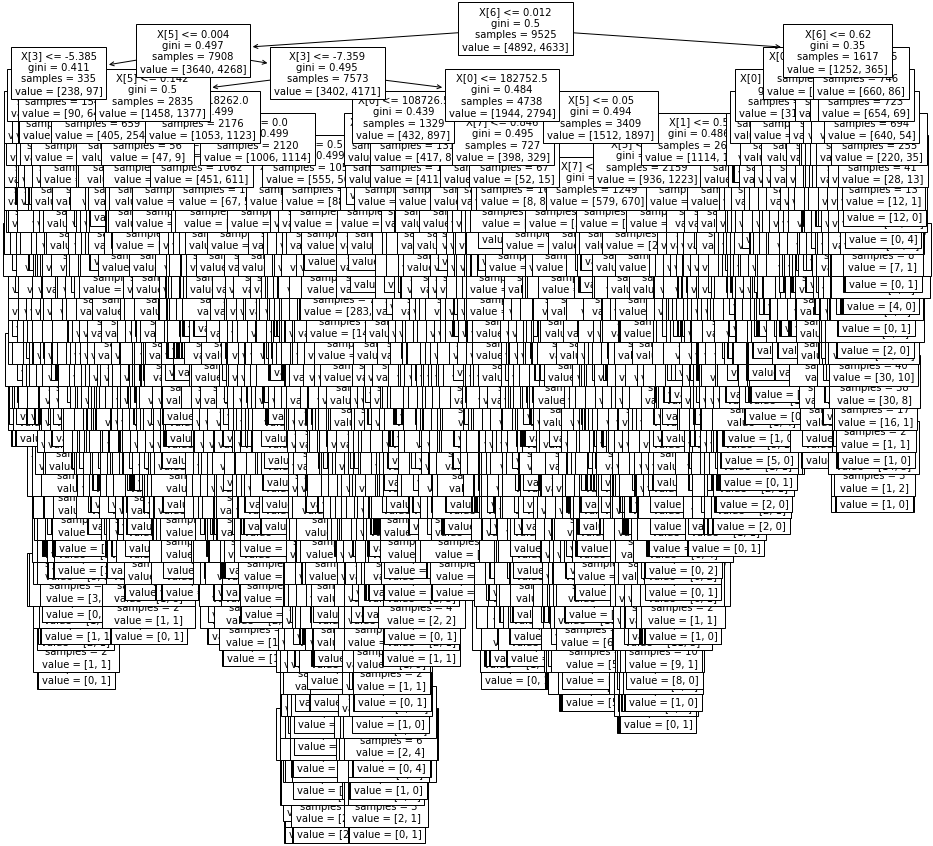

In [59]:
# 2a, determining feature importance
from sklearn import tree

plt.figure(figsize=(15,15))
tree.plot_tree(df, fontsize=10)
plt.show()

<AxesSubplot:>

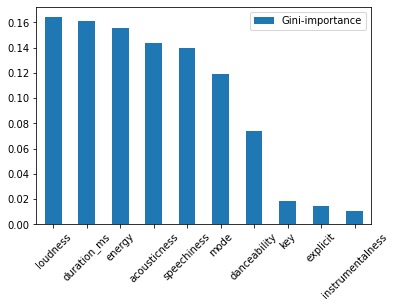

In [60]:
importances = rf.feature_importances_
std = np.std([tre.feature_importances_ for tre in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(test_features.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
importance = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importance.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X_train.shape[1]), importances[indices],
#         color="r", yerr=std[indices], align="center")
# plt.xticks(range(X_train.shape[1]), feats)
# plt.xlim([-1, X_train.shape[1]])
# plt.show()

Best Threshold=0.470000, G-Mean=0.626
Area under curve:  0.6877616747181965


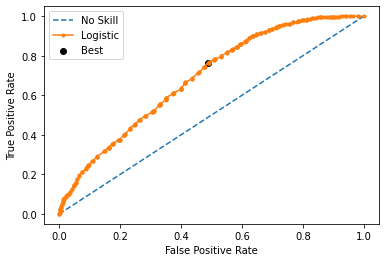

In [61]:
from matplotlib import pyplot

yhat = rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# 3b, calculate area under curve (AUC)
auc = metrics.roc_auc_score(Y_test, yhat)

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat)
    
# 3c, calculating optimal threshold
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
print('Area under curve: ', auc)

# 3a, plotting roc curve
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

# With Artist Features

In [80]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold = 0.05)
all_X = train_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity'])
all_Y = train_df['target']
all_X = sel.fit_transform(all_X)
all_X.shape

(25844, 12)

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test
logisticRegr.fit(x_train, y_train)

# Returns a NumPy Array
# Predict for One Observation (image)
predictions = logisticRegr.predict(x_test)

# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)
test_cm = metrics.confusion_matrix(Y_test, predictions)
print(test_cm)

test_features = test_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity'])
test_X = sel.transform(test_features)
test_Y = test_df['target']
test_predictions = logisticRegr.predict(test_X)
test_score = logisticRegr.score(test_X, test_Y)
print(test_score)
test_matrix = metrics.confusion_matrix(test_Y, test_predictions)
print(test_matrix)

0.6231379377055524
[[2182  374]
 [1574 1039]]
0.42939022448654673
[[1698 2119]
 [1465  999]]


In [82]:
for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)

Logistic Regression Train Accuracy: 0.6323095525997582
[[8733 1587]
 [6015 4340]]
Logistic Regression Test Accuracy: 0.6231379377055524
[[2182  374]
 [1574 1039]]
Naive Bayes Train Accuracy: 0.5949214026602176
[[10010   310]
 [ 8065  2290]]
Naive Bayes Test Accuracy: 0.5902495647127104
[[2490   66]
 [2052  561]]
k-Neighbors Train Accuracy: 0.8175574365175332
[[8509 1811]
 [1961 8394]]
k-Neighbors Test Accuracy: 0.7334107177403754
[[1891  665]
 [ 713 1900]]
Support Vector Machine Train Accuracy: 0.7335429262394196
[[8192 2128]
 [3381 6974]]
Support Vector Machine Test Accuracy: 0.7301218804410912
[[2027  529]
 [ 866 1747]]
Random Forest Train Accuracy: 0.997484885126965
[[10283    37]
 [   15 10340]]
Random Forest Test Accuracy: 0.7782936738247244
[[2021  535]
 [ 611 2002]]
Decision Tree Train Accuracy: 0.997484885126965
[[10308    12]
 [   40 10315]]
Decision Tree Test Accuracy: 0.710195395627781
[[1868  688]
 [ 810 1803]]


## Predicting 2020 Songs

In [84]:
for model, name in zip(models, names):
    pred = model.predict(test_X)
    test_score = model.score(test_X, test_Y)
    print(name + ' Test Accuracy: ', test_score)
    test_matrix = metrics.confusion_matrix(test_Y, pred)
    print(test_matrix)

Logistic Regression Test Accuracy:  0.42939022448654673
[[1698 2119]
 [1465  999]]
Naive Bayes Test Accuracy:  0.4152205062888075
[[2133 1684]
 [1989  475]]
k-Neighbors Test Accuracy:  0.5956057952555326
[[1986 1831]
 [ 709 1755]]
Support Vector Machine Test Accuracy:  0.5408374462665181
[[1812 2005]
 [ 879 1585]]
Random Forest Test Accuracy:  0.6007005253940455
[[1797 2020]
 [ 488 1976]]
Decision Tree Test Accuracy:  0.5616939977710556
[[1779 2038]
 [ 715 1749]]


# Using 2019 and 2020 to predict 2021 

In [87]:
tracks_df = pd.read_csv('new_tracks.csv')

train_index = tracks_df[tracks_df['release_year'] < 2019]
test_index = tracks_df[tracks_df['release_year'] != 2021]

# print(too_old.index)
train_df = tracks_df.drop(index=train_index.index, inplace=False)
train_index_1 = train_df[train_df['release_year'] > 2020]
train_df = train_df.drop(index=train_index_1.index, inplace=False)

test_df = tracks_df.drop(index=test_index.index, inplace=False)
train_df

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,target,release_year,followers
0,6Pkt6qVikqPBt9bEQy8iTz,A Lovers Concerto,41,159560,0,The Toys,6lH5PpuiMa5SpfjoIOlwCS,3/13/20,0.671,0.8670,...,0.0571,0.436,0.000000,0.1390,0.8390,120.689,4,False,2020,0
1,55qyghODi24yaDgKBI6lx0,The Circle Game - Live at The 2nd Fret Philade...,18,313093,0,Joni Mitchell,5hW4L92KnC6dX9t7tYM4Ve,10/30/20,0.644,0.2120,...,0.0347,0.881,0.000022,0.7980,0.4410,117.072,3,False,2020,971124
2,00xemFYjQNRpOlPhVaLAHa,Urge For Going - Live at The 2nd Fret Philadel...,18,295093,0,Joni Mitchell,5hW4L92KnC6dX9t7tYM4Ve,10/30/20,0.627,0.1840,...,0.0450,0.955,0.000162,0.0986,0.2990,115.864,4,False,2020,971124
3,26g4FBGTB9YEj7q4HlblFf,Brandy Eyes - Live at The 2nd Fret Philadelphi...,17,147907,0,Joni Mitchell,5hW4L92KnC6dX9t7tYM4Ve,10/30/20,0.442,0.3990,...,0.0780,0.930,0.000499,0.9120,0.5540,121.662,4,False,2020,971124
4,2lm5FQJRHvc3rUN5YHpEWj,Whats The Story Mr. Blue - Live at The 2nd Fre...,17,183440,0,Joni Mitchell,5hW4L92KnC6dX9t7tYM4Ve,10/30/20,0.581,0.3310,...,0.2430,0.888,0.000015,0.1470,0.6420,88.303,4,False,2020,971124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32119,0SjsIzJkZfDU7wlcdklEFR,John Browns Song,66,185250,0,Gregory Oberle,4MxqhahGRT4BPz1PilXGeu,3/20/20,0.562,0.0331,...,0.1030,0.996,0.961000,0.1110,0.3860,63.696,3,True,2020,91
32120,1ZwZsVZUiyFwIHMNpI3ERt,Skyscraper,4,106002,0,Emilie Chin,4USdOnfLczwUglA3TrdHs2,2/8/20,0.626,0.5300,...,0.0284,0.113,0.856000,0.1040,0.2150,120.113,4,False,2020,0
32121,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,阿YueYue,1QLBXKM5GCpyQQSVMNZqrZ,9/26/20,0.560,0.5180,...,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,False,2020,896
32122,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,ROLE MODEL,1dy5WNgIKQU6ezkpZs4y8z,10/21/20,0.765,0.6630,...,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,True,2020,245944


## Feature Selection, without artist features

In [88]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold = 0.05)
all_X = train_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'followers'])
all_Y = train_df['target']
all_X = sel.fit_transform(all_X)
all_X.shape

(25844, 11)

In [89]:
X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test
logisticRegr.fit(x_train, y_train)

# Returns a NumPy Array
# Predict for One Observation (image)
predictions = logisticRegr.predict(x_test)

# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)
test_cm = metrics.confusion_matrix(Y_test, predictions)
print(test_cm)

test_features = test_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'followers'])
test_X = sel.transform(test_features)
test_Y = test_df['target']
test_predictions = logisticRegr.predict(test_X)
test_score = logisticRegr.score(test_X, test_Y)
print(test_score)
test_matrix = metrics.confusion_matrix(test_Y, test_predictions)
print(test_matrix)

0.5616173341071774
[[1180 1425]
 [ 841 1723]]
0.5007164464257284
[[1232 2585]
 [ 551 1913]]


In [90]:
for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)

Logistic Regression Train Accuracy: 0.5585489721886336
[[4560 5711]
 [3416 6988]]
Logistic Regression Test Accuracy: 0.5616173341071774
[[1180 1425]
 [ 841 1723]]
Naive Bayes Train Accuracy: 0.5950181378476421
[[2817 7454]
 [ 919 9485]]
Naive Bayes Test Accuracy: 0.5852195782549816
[[ 689 1916]
 [ 228 2336]]
k-Neighbors Train Accuracy: 0.7198065296251511
[[7236 3035]
 [2758 7646]]
k-Neighbors Test Accuracy: 0.5730315341458696
[[1434 1171]
 [1036 1528]]
Support Vector Machine Train Accuracy: 0.5357194679564692
[[  754  9517]
 [   82 10322]]
Support Vector Machine Test Accuracy: 0.522344747533372
[[ 155 2450]
 [  19 2545]]
Random Forest Train Accuracy: 0.9972914147521161
[[10229    42]
 [   14 10390]]
Random Forest Test Accuracy: 0.665699361578642
[[1525 1080]
 [ 648 1916]]
Decision Tree Train Accuracy: 0.9972914147521161
[[10262     9]
 [   47 10357]]
Decision Tree Test Accuracy: 0.6065002901915264
[[1572 1033]
 [1001 1563]]


## Predicting 2021 Songs

In [91]:
for model, name in zip(models, names):
    pred = model.predict(test_X)
    test_score = model.score(test_X, test_Y)
    print(name + ' Test Accuracy: ', test_score)
    test_matrix = metrics.confusion_matrix(test_Y, pred)
    print(test_matrix)

Logistic Regression Test Accuracy:  0.5007164464257284
[[1232 2585]
 [ 551 1913]]
Naive Bayes Test Accuracy:  0.5225282598312371
[[ 958 2859]
 [ 140 2324]]
k-Neighbors Test Accuracy:  0.5180703709600382
[[1784 2033]
 [ 994 1470]]
Support Vector Machine Test Accuracy:  0.41346919280369365
[[ 164 3653]
 [  31 2433]]
Random Forest Test Accuracy:  0.5944913230377329
[[1705 2112]
 [ 435 2029]]
Decision Tree Test Accuracy:  0.5650374144244547
[[1981 1836]
 [ 896 1568]]


# Classification with artist features

In [93]:
all_X = train_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity'])
all_X = sel.fit_transform(all_X)
all_Y = train_df['target']

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test
logisticRegr.fit(x_train, y_train)

# Returns a NumPy Array
# Predict for One Observation (image)
predictions = logisticRegr.predict(x_test)

# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)
test_cm = metrics.confusion_matrix(Y_test, predictions)
print(test_cm)

test_X = test_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity'])
test_X = sel.transform(test_X)
test_Y = test_df['target']
test_predictions = logisticRegr.predict(x_test)
test_score = logisticRegr.score(x_test, y_test)
print(test_score)
test_matrix = metrics.confusion_matrix(y_test, test_predictions)
print(test_matrix)

0.636486747920294
[[2231  403]
 [1476 1059]]
0.636486747920294
[[2231  403]
 [1476 1059]]


In [94]:
for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)

Logistic Regression Train Accuracy: 0.6326481257557437
[[8652 1590]
 [6005 4428]]
Logistic Regression Test Accuracy: 0.636486747920294
[[2231  403]
 [1476 1059]]
Naive Bayes Train Accuracy: 0.5926964933494558
[[9952  290]
 [8131 2302]]
Naive Bayes Test Accuracy: 0.596053395240859
[[2549   85]
 [2003  532]]
k-Neighbors Train Accuracy: 0.8166384522370012
[[8413 1829]
 [1962 8471]]
k-Neighbors Test Accuracy: 0.7382472431804992
[[1938  696]
 [ 657 1878]]
Support Vector Machine Train Accuracy: 0.5246916565900847
[[  464  9778]
 [   49 10384]]
Support Vector Machine Test Accuracy: 0.5086090152834204
[[ 106 2528]
 [  12 2523]]
Random Forest Train Accuracy: 0.9973881499395405
[[10207    35]
 [   19 10414]]
Random Forest Test Accuracy: 0.7815825111240086
[[2046  588]
 [ 541 1994]]
Decision Tree Train Accuracy: 0.9973881499395405
[[10238     4]
 [   50 10383]]
Decision Tree Test Accuracy: 0.722189978719288
[[1888  746]
 [ 690 1845]]


## Predicting 2021 Songs

In [95]:
for model, name in zip(models, names):
    pred = model.predict(test_X)
    test_score = model.score(test_X, test_Y)
    print(name + ' Test Accuracy: ', test_score)
    test_matrix = metrics.confusion_matrix(test_Y, pred)
    print(test_matrix)

Logistic Regression Test Accuracy:  0.43528100620920235
[[1714 2103]
 [1444 1020]]
Naive Bayes Test Accuracy:  0.4144244547046649
[[2133 1684]
 [1994  470]]
k-Neighbors Test Accuracy:  0.5578729501671709
[[1729 2088]
 [ 689 1775]]
Support Vector Machine Test Accuracy:  0.40439420474446747
[[  98 3719]
 [  22 2442]]
Random Forest Test Accuracy:  0.5956057952555326
[[1759 2058]
 [ 482 1982]]
Decision Tree Test Accuracy:  0.5558032160483999
[[1738 2079]
 [ 711 1753]]


# Classification: Training and Testing Using Only 2021 Data

In [96]:
tracks_df = pd.read_csv('new_tracks.csv')

train_index = tracks_df[tracks_df['release_year'] != 2021]

# print(too_old.index)
train_df = tracks_df.drop(index=train_index.index, inplace=False)

### Without Artist Features

In [97]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold = 0.05)
all_X = train_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity', 'followers'])
all_Y = train_df['target']
all_X = sel.fit_transform(all_X)
all_X.shape

(6281, 10)

In [98]:
X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test
logisticRegr.fit(x_train, y_train)

# Returns a NumPy Array
# Predict for One Observation (image)
predictions = logisticRegr.predict(x_test)

# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)
test_cm = metrics.confusion_matrix(Y_test, predictions)
print(test_cm)

0.5998408910103421
[[754   0]
 [503   0]]


In [99]:
for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)

Logistic Regression Train Accuracy: 0.6096735668789809
[[3063    0]
 [1961    0]]
Logistic Regression Test Accuracy: 0.5998408910103421
[[754   0]
 [503   0]]
Naive Bayes Train Accuracy: 0.5523487261146497
[[1047 2016]
 [ 233 1728]]
Naive Bayes Test Accuracy: 0.5544948289578361
[[261 493]
 [ 67 436]]
k-Neighbors Train Accuracy: 0.7768710191082803
[[2611  452]
 [ 669 1292]]
k-Neighbors Test Accuracy: 0.6587112171837709
[[573 181]
 [248 255]]
Support Vector Machine Train Accuracy: 0.6096735668789809
[[3063    0]
 [1961    0]]
Support Vector Machine Test Accuracy: 0.5998408910103421
[[754   0]
 [503   0]]
Random Forest Train Accuracy: 0.9926353503184714
[[3038   25]
 [  12 1949]]
Random Forest Test Accuracy: 0.7525855210819411
[[602 152]
 [159 344]]
Decision Tree Train Accuracy: 0.9926353503184714
[[3052   11]
 [  26 1935]]
Decision Tree Test Accuracy: 0.7334924423229913
[[606 148]
 [187 316]]


### With Artist Features

In [ ]:
all_X = train_df.drop(columns=['target', 'artists', 'id_artists', 'id', 'name', 'release_date', 'popularity'])
all_X = sel.fit_transform(all_X)
all_Y = train_df['target']

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

# all parameters not specified are set to their defaults
x_train = X_train
y_train = Y_train
x_test = X_test
y_test = Y_test
logisticRegr.fit(x_train, y_train)

# Returns a NumPy Array
# Predict for One Observation (image)
predictions = logisticRegr.predict(x_test)

# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)
test_cm = metrics.confusion_matrix(Y_test, predictions)
print(test_cm)

0.6085918854415274
[[765   0]
 [492   0]]


In [101]:
for model, name in zip(models, names):
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_cm = metrics.confusion_matrix(Y_train, train_pred)
    test_cm = metrics.confusion_matrix(Y_test, pred)
    print(name + ' Train Accuracy: {}'.format(model.score(X_train, Y_train)))
    print(train_cm)
    print(name + ' Test Accuracy: {}'.format(np.sum(pred==Y_test)/len(Y_test)) )
    print(test_cm)

Logistic Regression Train Accuracy: 0.607484076433121
[[3052    0]
 [1972    0]]
Logistic Regression Test Accuracy: 0.6085918854415274
[[765   0]
 [492   0]]
Naive Bayes Train Accuracy: 0.5644904458598726
[[1158 1894]
 [ 294 1678]]
Naive Bayes Test Accuracy: 0.5600636435958631
[[282 483]
 [ 70 422]]
k-Neighbors Train Accuracy: 0.7740843949044586
[[2588  464]
 [ 671 1301]]
k-Neighbors Test Accuracy: 0.6587112171837709
[[578 187]
 [242 250]]
Support Vector Machine Train Accuracy: 0.607484076433121
[[3052    0]
 [1972    0]]
Support Vector Machine Test Accuracy: 0.6085918854415274
[[765   0]
 [492   0]]
Random Forest Train Accuracy: 0.9924363057324841
[[3030   22]
 [  16 1956]]
Random Forest Test Accuracy: 0.7907716785998409
[[631 134]
 [129 363]]
Decision Tree Train Accuracy: 0.9924363057324841
[[3042   10]
 [  28 1944]]
Decision Tree Test Accuracy: 0.741447891805887
[[630 135]
 [190 302]]


# Predicting Popularity

In [28]:
# read in the data
tracks_df = pd.read_csv('tracks.csv')
tracks_df.head(5)

# create new column that says whether song is by Billie Eilish  
# print(len(tracks_df[tracks_df.loc[:,'artists'].str.contains('Billie Eilish')]))
# tracks_df['target'] = tracks_df.loc[:,'artists'].str.contains('Billie Eilish')

# create new column that says whether song is popular or not 
# print(len(tracks_df[tracks_df['popularity'] > 50]))
# tracks_df['target'] = tracks_df['popularity'] > 50

# Drop old songs
tracks_df['date'] = pd.to_datetime(tracks_df['release_date'])
tracks_df['release_year'] = tracks_df['date'].dt.year
tracks_df = tracks_df.drop(['date'], axis=1)
train_index = tracks_df[tracks_df['release_year'] != 2020]
test_index = tracks_df[tracks_df['release_year'] != 2021]
# print(too_old.index)
train_df = tracks_df.drop(index=train_index.index, inplace=False)

test_df = tracks_df.drop(index=test_index.index, inplace=False)

print(len(train_df))
print(len(test_df))

# print(len(tracks_df[tracks_df.loc[:,'artists'].str.contains('Billie Eilish')]))
tracks_df.columns
tracks_df

13937
6281


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,1922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,...,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,2020
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,...,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,2020
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,...,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,2020
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,...,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,2021


## Linear Regression

In [31]:
from sklearn import linear_model

all_X = train_df.drop(columns=['artists', 'id_artists', 'id', 'name', 'release_date', 'popularity'])
all_Y = train_df['popularity']

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size = 0.2)

reg = linear_model.LinearRegression()
reg = reg.fit(X_train, Y_train)

test_X = test_df.drop(columns=['artists', 'id_artists', 'id', 'name', 'release_date', 'popularity'])
test_Y = test_df['popularity']

print('Training score:',reg.score(X_train, Y_train))
# pred = reg.predict(test_selected_df)
print('Test score:', reg.score(X_test, Y_test))
print('2021 Prediction Score:', reg.score(test_X, test_Y))

Training score: 0.2922474303257524
Test score: 0.29808902338954635
2021 Prediction Score: -0.011854937801674126


In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
print(Y_train.shape)
train_mean = np.full((11149,), np.mean(Y_train))

print(test_Y.shape)
test_mean = np.full((6281,), np.mean(test_Y))

print('Baseline Train MSE:', mean_squared_error(Y_train, train_mean))
print('Train MSE:', mean_squared_error(Y_train, reg.predict(X_train)))
print('Baseline Test MSE:', mean_squared_error(test_Y, test_mean))
print('Test MSE:', mean_squared_error(test_Y, reg.predict(test_X)))
print()
print('Baseline Train RMSE:', math.sqrt(mean_squared_error(Y_train, train_mean)))
print('Train RMSE:', math.sqrt(mean_squared_error(Y_train, reg.predict(X_train))))
print('Baseline Test RMSE:', math.sqrt(mean_squared_error(test_Y, test_mean)))
print('Test RMSE:', math.sqrt(mean_squared_error(test_Y, reg.predict(test_X))))
print()
print('Baseline Train MAE:', mean_absolute_error(Y_train, train_mean))
print('Train MAE:', mean_absolute_error(Y_train, reg.predict(X_train)))
print('Baseline Test MAE:', mean_absolute_error(test_Y, test_mean))
print('Test MAE:', mean_absolute_error(test_Y, reg.predict(test_X)))
print()
print('Baseline Train R2:', r2_score(Y_train, train_mean))
print('Train R2:', r2_score(Y_train, reg.predict(X_train)))
print('Baseline Test R2:', r2_score(test_Y, test_mean))
print('Test R2:', r2_score(test_Y, reg.predict(test_X)))
print()

(11149,)
(6281,)
Baseline Train MSE: 546.7173048577773
Train MSE: 386.9405773984709
Baseline Test MSE: 809.1150808214786
Test MSE: 818.7070897790138

Baseline Train RMSE: 23.38198676027718
Train RMSE: 19.670805204629293
Baseline Test RMSE: 28.444948247825636
Test RMSE: 28.613058029141413

Baseline Train MAE: 18.877241268499642
Train MAE: 15.322042942195106
Baseline Test MAE: 26.17644416824219
Test MAE: 23.424505643977742

Baseline Train R2: 0.0
Train R2: 0.2922474303257524
Baseline Test R2: 0.0
Test R2: -0.011854937801674126



## Ridge Regression

In [38]:
# Ridge Regression

ridge = linear_model.RidgeCV()
ridge = ridge.fit(X_train, Y_train)

print('Baseline Train MSE:', mean_squared_error(Y_train, train_mean))
print('Train MSE:', mean_squared_error(Y_train, ridge.predict(X_train)))
print('Baseline Test MSE:', mean_squared_error(test_Y, test_mean))
print('Test MSE:', mean_squared_error(test_Y, ridge.predict(test_X)))
print()
print('Baseline Train RMSE:', math.sqrt(mean_squared_error(Y_train, train_mean)))
print('Train RMSE:', math.sqrt(mean_squared_error(Y_train, ridge.predict(X_train))))
print('Baseline Test RMSE:', math.sqrt(mean_squared_error(test_Y, test_mean)))
print('Test RMSE:', math.sqrt(mean_squared_error(test_Y, ridge.predict(test_X))))
print()
print('Baseline Train MAE:', mean_absolute_error(Y_train, train_mean))
print('Train MAE:', mean_absolute_error(Y_train, ridge.predict(X_train)))
print('Baseline Test MAE:', mean_absolute_error(test_Y, test_mean))
print('Test MAE:', mean_absolute_error(test_Y, ridge.predict(test_X)))
print()
print('Baseline Train R2:', r2_score(Y_train, train_mean))
print('Train R2:', r2_score(Y_train, ridge.predict(X_train)))
print('Baseline Test R2:', r2_score(test_Y, test_mean))
print('Test R2:', r2_score(test_Y, ridge.predict(test_X)))
print()

Baseline Train MSE: 546.7173048577773
Train MSE: 386.943170697409
Baseline Test MSE: 809.1150808214786
Test MSE: 818.6619234677206

Baseline Train RMSE: 23.38198676027718
Train RMSE: 19.6708711219765
Baseline Test RMSE: 28.444948247825636
Test RMSE: 28.612268757785017

Baseline Train MAE: 18.877241268499642
Train MAE: 15.32191455131046
Baseline Test MAE: 26.17644416824219
Test MAE: 23.42272836150763

Baseline Train R2: 0.0
Train R2: 0.2922426869256166
Baseline Test R2: 0.0
Test R2: -0.011799115938549987



## Lasso Regression

In [40]:
# lasso regression

lasso = linear_model.LassoCV()
lasso = lasso.fit(X_train, Y_train)

print('Baseline Train MSE:', mean_squared_error(Y_train, train_mean))
print('Train MSE:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('Baseline Test MSE:', mean_squared_error(test_Y, test_mean))
print('Test MSE:', mean_squared_error(test_Y, lasso.predict(test_X)))
print()
print('Baseline Train RMSE:', math.sqrt(mean_squared_error(Y_train, train_mean)))
print('Train RMSE:', math.sqrt(mean_squared_error(Y_train, lasso.predict(X_train))))
print('Baseline Test RMSE:', math.sqrt(mean_squared_error(test_Y, test_mean)))
print('Test RMSE:', math.sqrt(mean_squared_error(test_Y, lasso.predict(test_X))))
print()
print('Baseline Train MAE:', mean_absolute_error(Y_train, train_mean))
print('Train MAE:', mean_absolute_error(Y_train, lasso.predict(X_train)))
print('Baseline Test MAE:', mean_absolute_error(test_Y, test_mean))
print('Test MAE:', mean_absolute_error(test_Y, lasso.predict(test_X)))
print()
print('Baseline Train R2:', r2_score(Y_train, train_mean))
print('Train R2:', r2_score(Y_train, lasso.predict(X_train)))
print('Baseline Test R2:', r2_score(test_Y, test_mean))
print('Test R2:', r2_score(test_Y, lasso.predict(test_X)))
print()

Baseline Train MSE: 546.7173048577773
Train MSE: 533.9622620972917
Baseline Test MSE: 809.1150808214786
Test MSE: 893.897216160707

Baseline Train RMSE: 23.38198676027718
Train RMSE: 23.10762346277288
Baseline Test RMSE: 28.444948247825636
Test RMSE: 29.89811392313413

Baseline Train MAE: 18.877241268499642
Train MAE: 18.742282641334363
Baseline Test MAE: 26.17644416824219
Test MAE: 25.7306023550049

Baseline Train R2: 0.0
Train R2: 0.023330234194441024
Baseline Test R2: 0.0
Test R2: -0.10478377841276987



## ElasticNet Regression

In [42]:
# ElasticNet Regression

elastic = linear_model.ElasticNetCV()
elastic = elastic.fit(X_train, Y_train)

print('Baseline Train MSE:', mean_squared_error(Y_train, train_mean))
print('Train MSE:', mean_squared_error(Y_train, elastic.predict(X_train)))
print('Baseline Test MSE:', mean_squared_error(test_Y, test_mean))
print('Test MSE:', mean_squared_error(test_Y, elastic.predict(test_X)))
print()
print('Baseline Train RMSE:', math.sqrt(mean_squared_error(Y_train, train_mean)))
print('Train RMSE:', math.sqrt(mean_squared_error(Y_train, elastic.predict(X_train))))
print('Baseline Test RMSE:', math.sqrt(mean_squared_error(test_Y, test_mean)))
print('Test RMSE:', math.sqrt(mean_squared_error(test_Y, elastic.predict(test_X))))
print()
print('Baseline Train MAE:', mean_absolute_error(Y_train, train_mean))
print('Train MAE:', mean_absolute_error(Y_train, elastic.predict(X_train)))
print('Baseline Test MAE:', mean_absolute_error(test_Y, test_mean))
print('Test MAE:', mean_absolute_error(test_Y, elastic.predict(test_X)))
print()
print('Baseline Train R2:', r2_score(Y_train, train_mean))
print('Train R2:', r2_score(Y_train, elastic.predict(X_train)))
print('Baseline Test R2:', r2_score(test_Y, test_mean))
print('Test R2:', r2_score(test_Y, elastic.predict(test_X)))
print()

Baseline Train MSE: 546.7173048577773
Train MSE: 533.9622620984629
Baseline Test MSE: 809.1150808214786
Test MSE: 893.8972158003546

Baseline Train RMSE: 23.38198676027718
Train RMSE: 23.107623462798223
Baseline Test RMSE: 28.444948247825636
Test RMSE: 29.898113917107793

Baseline Train MAE: 18.877241268499642
Train MAE: 18.742282639738566
Baseline Test MAE: 26.17644416824219
Test MAE: 25.730602355554435

Baseline Train R2: 0.0
Train R2: 0.023330234192298738
Baseline Test R2: 0.0
Test R2: -0.10478377796740412



## Graph Residuals

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


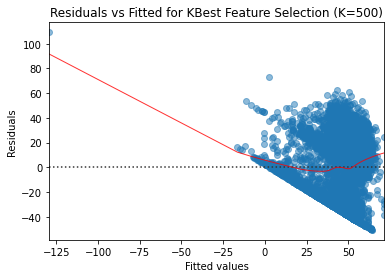

In [50]:
# Graph Ridge Regression Residuals
import matplotlib.pyplot as plt
import seaborn as sns
!pip install statsmodels

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(ridge.predict(test_X), test_Y,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted for KBest Feature Selection (K=500)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');